# Dog breed classification

Below are the required libraries

In [1]:
from PIL import Image
from pylab import rcParams
from skimage import io, transform
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

import os
import pandas as pd
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

%reload_ext autoreload
%matplotlib inline
torch.cuda.set_device(0)

## Load the dataset

In [2]:
class CSVData(Dataset):
    def __init__(self, label_df, classes, class_indexes, data_dir, transform):
        self.label = label_df
        self.data_dir = data_dir
        self.transform = transform
        self.classes = classes
        self.class_indexes = class_indexes

    def __len__(self):
        return len(self.label) - 1

    def __getitem__(self, idx):
        label = self.label.iloc[idx, 1]
        img_path = os.path.join(self.data_dir, self.label.iloc[idx, 0] + '.jpg')
        image = self.transform(Image.open(img_path).convert('RGB'))

        return image, self.class_indexes[label]

## Transform the data

The transforms are optimal transformations obtained from the kaggle competition.
First the images are resized to 224x224, and then they are randomly flipped horizontally. Finally they are normalized, with mean being [0.485, 0.456, 0.406] and std being [0.229, 0.224, 0.225]. All these transformations are expected by pre-trained pytorch models as stated in their documentation.
https://pytorch.org/docs/stable/torchvision/models.html

After image transformation is complete, the dataloaders are created. I have set batch_size=16 to save VRAM. 

All this preprocessing is done to the entire dataset which is split into training and testing partitions.

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
labels = pd.read_csv('data/labels.csv')

classes = list(labels.breed.unique())
class_indexes = {classes[i]: i for i in range(0, len(classes))}
class_names = classes


train, evaluation = train_test_split(labels, test_size=0.15)
image_datasets = {'train': CSVData(train, classes, class_indexes, 'data/train_images', data_transforms['train']),
                 'test': CSVData(evaluation, classes, class_indexes, 'data/train_images', data_transforms['test'])}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=0)
                  for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

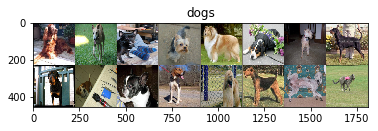

In [4]:
def show_images(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)
show_images(out, title='dogs')

### Class distribution

We can see, that the class distribution of the dataset is reasonably good, though the larges class is nearly twice more common than the least common one. This means that the rarest classes like rottweiler and cockerspaniel are classified slightly more rarely than the others. This is however not the only problem in classification as several dog breeds appear similar. One example of this is the different labrador variants. The only real difference in appearance is their color.

Text(0.5, 1.0, 'Figure 1: Class distribution in the tranining set')

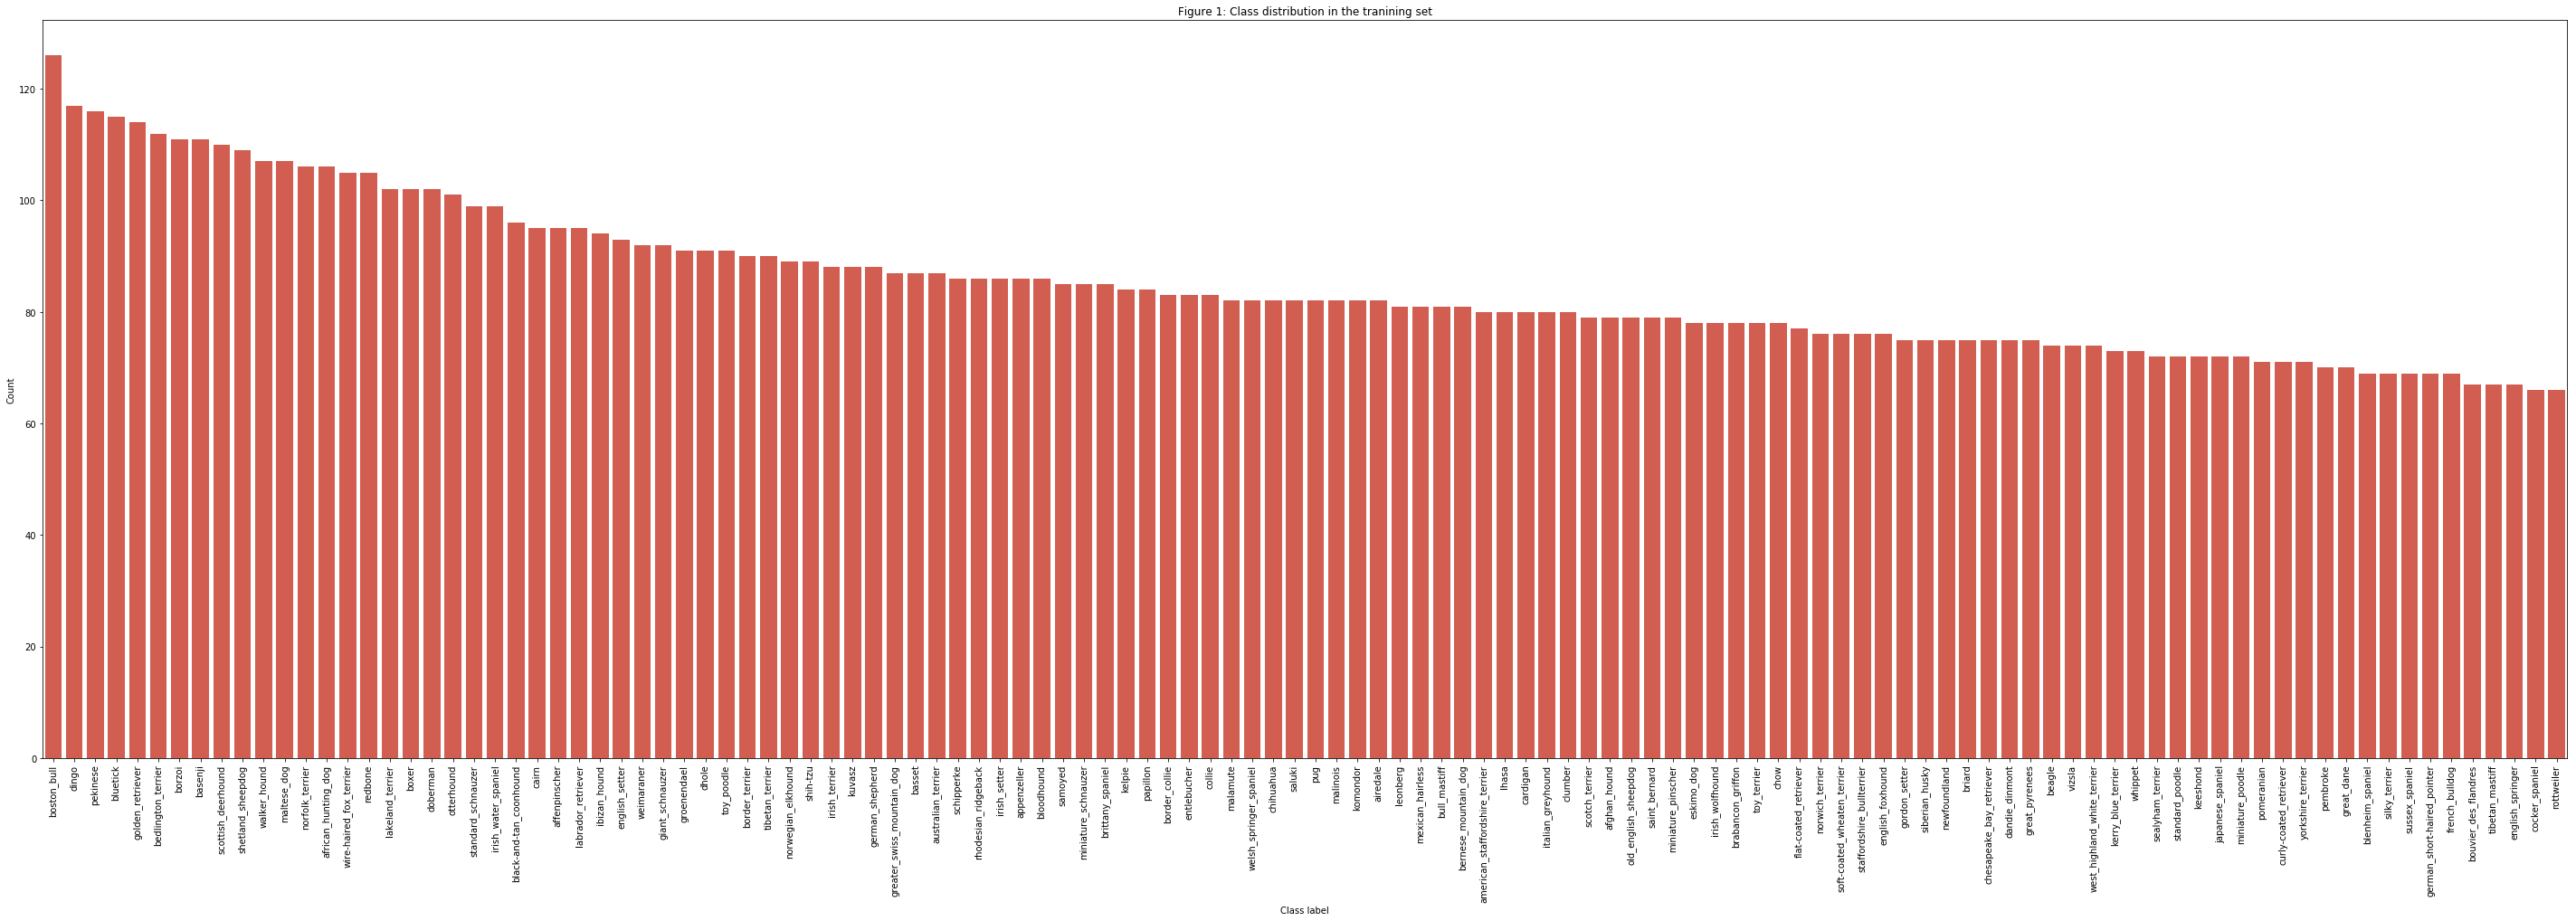

In [5]:
labels_data = pd.read_csv('data/labels.csv')
class_distribution = labels_data["breed"].value_counts()
fig = plt.figure(figsize=(50, 15))
fig.clf()
#ax = plt.subplot()
ax = sns.barplot(x=class_distribution.index, y=class_distribution, color='#e74c3c', ax=plt.subplot())
ax.set_xticklabels(class_names, rotation='vertical', fontsize=10)
ax.set_xlabel('Class label')
ax.set_ylabel('Count')
ax.set_title('Figure 1: Class distribution in the tranining set')

## Training function

Here I define the training function which is used to train each model. First I define that I will be using GPU to train the models, and the criterion.

The training function evaluates the accuracy of the model every 200 steps. Finally the model is saved in a file.

In [6]:
device = torch.device("cuda")

def train_model(model, criterion, optimizer, name, num_epochs=25):
    start_time = datetime.datetime.now()
    steps = 0
    running_loss = 0.0
    print_every = 200
    n_test = len(dataloaders["test"])
    n_train = len(dataloaders["train"])
    train_losses, test_losses = [], []
    for epoch in range(num_epochs):
        for inputs, labels in dataloaders["train"]:
            inputs, labels = inputs.to(device), labels.to(device)
            steps += 1
            optimizer.zero_grad()
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if steps % print_every == 0:
                test_loss = 0
                accuracy = 0
                model.eval()
                with torch.no_grad():
                    for inputs, labels in dataloaders["test"]:
                        inputs, labels = inputs.to(device), labels.to(device)
                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, labels)
                        test_loss += batch_loss.item()

                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = (top_class == labels.view(*top_class.shape))
                        accuracy +=torch.mean(equals.type(torch.FloatTensor)).item()
                train_losses.append(running_loss/n_train)
                test_losses.append(test_loss/n_test)                    
                print(f"Epoch {epoch+1}/{num_epochs} ", end=' ')
                print(f"Train loss: {running_loss/print_every:.3f}", end=' ')
                print(f"Test loss: {test_loss/n_test:.3f}", end=' ')
                print(f"Test accuracy: {accuracy/n_test:.3f}")
                running_loss = 0.0
                model.train()
    torch.save(model, name + '.pth')
    end_time = datetime.datetime.now()
    timedelta = end_time - start_time
    print(f"It took {timedelta} to train {name}")

## Create the models

### Resnet50 with Single trainable layer

The first model I will train is resnet50 (pretrained). After setting the pretrained model, the layers are "frozen", so the training does not affect them. Then the final layer is set as a single linear layer, which outputs in the 120 dog-classes. 
Then the optimizer is created with optim.SGD. Finally the model is set to cuda device to speed up training.

In [7]:
resnet_model = models.resnet50(pretrained=True)
for param in resnet_model.parameters():
    param.requires_grad = False

resnet_model.fc = nn.Linear(resnet_model.fc.in_features, len(class_names))

resnet_optimizer = optim.SGD(resnet_model.fc.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss().cuda()

resnet_model = resnet_model.cuda()

### Training Resnet50

In [8]:
train_model(resnet_model, criterion, resnet_optimizer, "resnet50-2")

Epoch 1/25  Train loss: 4.316 Test loss: 3.564 Test accuracy: 0.398
Epoch 1/25  Train loss: 3.258 Test loss: 2.590 Test accuracy: 0.569
Epoch 2/25  Train loss: 2.496 Test loss: 1.916 Test accuracy: 0.698
Epoch 2/25  Train loss: 2.008 Test loss: 1.549 Test accuracy: 0.739
Epoch 2/25  Train loss: 1.692 Test loss: 1.335 Test accuracy: 0.765
Epoch 3/25  Train loss: 1.487 Test loss: 1.169 Test accuracy: 0.769
Epoch 3/25  Train loss: 1.305 Test loss: 1.067 Test accuracy: 0.775
Epoch 3/25  Train loss: 1.200 Test loss: 0.974 Test accuracy: 0.798
Epoch 4/25  Train loss: 1.079 Test loss: 0.898 Test accuracy: 0.792
Epoch 4/25  Train loss: 1.040 Test loss: 0.878 Test accuracy: 0.796
Epoch 5/25  Train loss: 0.985 Test loss: 0.818 Test accuracy: 0.815
Epoch 5/25  Train loss: 0.893 Test loss: 0.816 Test accuracy: 0.803
Epoch 5/25  Train loss: 0.907 Test loss: 0.774 Test accuracy: 0.820
Epoch 6/25  Train loss: 0.869 Test loss: 0.749 Test accuracy: 0.824
Epoch 6/25  Train loss: 0.840 Test loss: 0.758 T

### Resnet50 results

The resulting accuracy was approximately 82%, not bad for such simple network and short training. The training took 44 minutes, though the GPU was simultaniously used in its original purpose.

### VGG16
from https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch

I simply take the pretrained vgg16 model, and replace its last layer with my own.

In [9]:
vgg_model = models.vgg16(pretrained=True)
for param in vgg_model.parameters():
    param.requires_grad = False

vgg_model.classifier[-1] = nn.Linear(vgg_model.classifier[-1].in_features, len(class_names))
vgg_optimizer = optim.SGD(vgg_model.classifier.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss().cuda()

vgg_model = vgg_model.cuda()

### Training VGG16

In [10]:
train_model(vgg_model, criterion, vgg_optimizer, "vgg16-2")

Epoch 1/25  Train loss: 2.414 Test loss: 1.147 Test accuracy: 0.735
Epoch 1/25  Train loss: 1.102 Test loss: 0.850 Test accuracy: 0.778
Epoch 2/25  Train loss: 0.876 Test loss: 0.751 Test accuracy: 0.790
Epoch 2/25  Train loss: 0.726 Test loss: 0.696 Test accuracy: 0.816
Epoch 2/25  Train loss: 0.722 Test loss: 0.686 Test accuracy: 0.797
Epoch 3/25  Train loss: 0.681 Test loss: 0.668 Test accuracy: 0.803
Epoch 3/25  Train loss: 0.616 Test loss: 0.655 Test accuracy: 0.802
Epoch 3/25  Train loss: 0.619 Test loss: 0.626 Test accuracy: 0.814
Epoch 4/25  Train loss: 0.555 Test loss: 0.647 Test accuracy: 0.810
Epoch 4/25  Train loss: 0.577 Test loss: 0.628 Test accuracy: 0.816
Epoch 5/25  Train loss: 0.548 Test loss: 0.621 Test accuracy: 0.814
Epoch 5/25  Train loss: 0.515 Test loss: 0.626 Test accuracy: 0.804
Epoch 5/25  Train loss: 0.497 Test loss: 0.651 Test accuracy: 0.799
Epoch 6/25  Train loss: 0.514 Test loss: 0.618 Test accuracy: 0.808
Epoch 6/25  Train loss: 0.459 Test loss: 0.631 T

### Resnet50 and VGG16

Both networks reached a respectable accuracy of 80%, though in both cases the last 10-15 epochs did not yield any improvement. I next will attempt the same with more slightly advanced networks before more complete evaluation.

### Resnet152 with multiple trainable layers

This time I will be using resnet152 with more complex trainable layers. I expect that it's accuracy would be at least the same as in the resnet50 previously.

In [7]:
resnet152_model = models.resnet152(pretrained=True)
for param in resnet152_model.parameters():
    param.requires_grad = False

resnet152_model.fc = nn.Sequential(
                nn.Linear(resnet152_model.fc.in_features, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.1),
                nn.Linear(4096, len(class_names)),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.1),
            )

resnet152_optimizer = optim.SGD(resnet152_model.fc.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss().cuda()

resnet152_model = resnet152_model.cuda()

### Training Resnet152

In [15]:
train_model(resnet152_model, criterion, resnet152_optimizer, "resnet152")

Epoch 1/25  Train loss: 4.612 Test loss: 4.330 Test accuracy: 0.258
Epoch 1/25  Train loss: 4.167 Test loss: 3.725 Test accuracy: 0.387
Epoch 2/25  Train loss: 3.573 Test loss: 3.115 Test accuracy: 0.483
Epoch 2/25  Train loss: 3.101 Test loss: 2.706 Test accuracy: 0.554
Epoch 2/25  Train loss: 2.868 Test loss: 2.455 Test accuracy: 0.585
Epoch 3/25  Train loss: 2.683 Test loss: 2.280 Test accuracy: 0.603
Epoch 3/25  Train loss: 2.568 Test loss: 2.142 Test accuracy: 0.614
Epoch 3/25  Train loss: 2.515 Test loss: 2.045 Test accuracy: 0.630
Epoch 4/25  Train loss: 2.369 Test loss: 1.995 Test accuracy: 0.636
Epoch 4/25  Train loss: 2.407 Test loss: 1.946 Test accuracy: 0.641
Epoch 5/25  Train loss: 2.251 Test loss: 1.918 Test accuracy: 0.634
Epoch 5/25  Train loss: 2.351 Test loss: 1.898 Test accuracy: 0.634
Epoch 5/25  Train loss: 2.264 Test loss: 1.876 Test accuracy: 0.630
Epoch 6/25  Train loss: 2.260 Test loss: 1.860 Test accuracy: 0.637
Epoch 6/25  Train loss: 2.273 Test loss: 1.836 T

In [8]:
train_model(resnet152_model, criterion, resnet152_optimizer, "resnet152-50", num_epochs=50)

Epoch 1/50  Train loss: 4.659 Test loss: 4.487 Test accuracy: 0.170
Epoch 1/50  Train loss: 4.307 Test loss: 4.034 Test accuracy: 0.346
Epoch 2/50  Train loss: 3.890 Test loss: 3.655 Test accuracy: 0.377
Epoch 2/50  Train loss: 3.582 Test loss: 3.361 Test accuracy: 0.416
Epoch 2/50  Train loss: 3.286 Test loss: 3.133 Test accuracy: 0.454
Epoch 3/50  Train loss: 3.162 Test loss: 3.024 Test accuracy: 0.458
Epoch 3/50  Train loss: 3.058 Test loss: 2.937 Test accuracy: 0.465
Epoch 3/50  Train loss: 3.012 Test loss: 2.884 Test accuracy: 0.478
Epoch 4/50  Train loss: 2.942 Test loss: 2.836 Test accuracy: 0.473
Epoch 4/50  Train loss: 2.881 Test loss: 2.795 Test accuracy: 0.486
Epoch 5/50  Train loss: 2.912 Test loss: 2.770 Test accuracy: 0.498
Epoch 5/50  Train loss: 2.835 Test loss: 2.746 Test accuracy: 0.484
Epoch 5/50  Train loss: 2.820 Test loss: 2.729 Test accuracy: 0.487
Epoch 6/50  Train loss: 2.760 Test loss: 2.720 Test accuracy: 0.483
Epoch 6/50  Train loss: 2.738 Test loss: 2.680 T

Epoch 45/50  Train loss: 2.195 Test loss: 2.254 Test accuracy: 0.555
Epoch 45/50  Train loss: 2.268 Test loss: 2.234 Test accuracy: 0.562
Epoch 45/50  Train loss: 2.181 Test loss: 2.234 Test accuracy: 0.559
Epoch 46/50  Train loss: 2.167 Test loss: 2.262 Test accuracy: 0.555
Epoch 46/50  Train loss: 2.202 Test loss: 2.242 Test accuracy: 0.564
Epoch 47/50  Train loss: 2.172 Test loss: 2.240 Test accuracy: 0.561
Epoch 47/50  Train loss: 2.172 Test loss: 2.231 Test accuracy: 0.563
Epoch 47/50  Train loss: 2.267 Test loss: 2.248 Test accuracy: 0.561
Epoch 48/50  Train loss: 2.191 Test loss: 2.248 Test accuracy: 0.559
Epoch 48/50  Train loss: 2.150 Test loss: 2.239 Test accuracy: 0.568
Epoch 48/50  Train loss: 2.204 Test loss: 2.239 Test accuracy: 0.558
Epoch 49/50  Train loss: 2.164 Test loss: 2.242 Test accuracy: 0.562
Epoch 49/50  Train loss: 2.203 Test loss: 2.239 Test accuracy: 0.561
Epoch 49/50  Train loss: 2.169 Test loss: 2.240 Test accuracy: 0.563
Epoch 50/50  Train loss: 2.201 Tes

In [8]:
train_model(resnet152_model, criterion, resnet152_optimizer, "resnet152")

Epoch 1/25  Train loss: 4.638 Test loss: 4.371 Test accuracy: 0.256
Epoch 1/25  Train loss: 4.220 Test loss: 3.753 Test accuracy: 0.449
Epoch 2/25  Train loss: 3.710 Test loss: 3.221 Test accuracy: 0.518
Epoch 2/25  Train loss: 3.294 Test loss: 2.815 Test accuracy: 0.566
Epoch 2/25  Train loss: 3.081 Test loss: 2.620 Test accuracy: 0.553
Epoch 3/25  Train loss: 2.867 Test loss: 2.439 Test accuracy: 0.572
Epoch 3/25  Train loss: 2.733 Test loss: 2.284 Test accuracy: 0.596
Epoch 3/25  Train loss: 2.722 Test loss: 2.223 Test accuracy: 0.593
Epoch 4/25  Train loss: 2.615 Test loss: 2.150 Test accuracy: 0.609
Epoch 4/25  Train loss: 2.529 Test loss: 2.099 Test accuracy: 0.621
Epoch 5/25  Train loss: 2.495 Test loss: 2.081 Test accuracy: 0.612
Epoch 5/25  Train loss: 2.525 Test loss: 2.082 Test accuracy: 0.604
Epoch 5/25  Train loss: 2.392 Test loss: 2.031 Test accuracy: 0.622
Epoch 6/25  Train loss: 2.423 Test loss: 2.025 Test accuracy: 0.612
Epoch 6/25  Train loss: 2.449 Test loss: 1.999 T

### Densenet

Trying densenet with the same setup from other networks.

In [10]:
densenet_model = models.densenet161(pretrained=True)
for param in densenet_model.parameters():
    param.requires_grad = False

densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, len(class_names))
densenet_optimizer = torch.optim.Adam(densenet_model.parameters())
criterion = nn.CrossEntropyLoss().cuda()

densenet_model = densenet_model.cuda()

In [11]:
train_model(densenet_model, criterion, densenet_optimizer, "densenet")

Epoch 1/25  Train loss: 2.897 Test loss: 1.273 Test accuracy: 0.704
Epoch 1/25  Train loss: 1.220 Test loss: 0.810 Test accuracy: 0.792
Epoch 2/25  Train loss: 0.897 Test loss: 0.699 Test accuracy: 0.793
Epoch 2/25  Train loss: 0.626 Test loss: 0.635 Test accuracy: 0.807
Epoch 2/25  Train loss: 0.592 Test loss: 0.555 Test accuracy: 0.840
Epoch 3/25  Train loss: 0.513 Test loss: 0.552 Test accuracy: 0.837
Epoch 3/25  Train loss: 0.445 Test loss: 0.551 Test accuracy: 0.828
Epoch 3/25  Train loss: 0.458 Test loss: 0.574 Test accuracy: 0.826
Epoch 4/25  Train loss: 0.368 Test loss: 0.559 Test accuracy: 0.825
Epoch 4/25  Train loss: 0.361 Test loss: 0.541 Test accuracy: 0.829
Epoch 5/25  Train loss: 0.330 Test loss: 0.554 Test accuracy: 0.834
Epoch 5/25  Train loss: 0.276 Test loss: 0.532 Test accuracy: 0.834
Epoch 5/25  Train loss: 0.297 Test loss: 0.570 Test accuracy: 0.834
Epoch 6/25  Train loss: 0.271 Test loss: 0.539 Test accuracy: 0.826
Epoch 6/25  Train loss: 0.233 Test loss: 0.552 T

### Densenet results

Densenet reaches accuracy of 83%, similar as in vgg and resnet. It also took 52 minutes, a bit longer than vgg/resnet

### Alexnet

Here I use the classic alexnet, just as the other networks.

In [6]:
alexnet_model = models.alexnet(pretrained=True)
for param in alexnet_model.parameters():
    param.requires_grad = False
alexnet_model.classifier[-1] = nn.Linear(in_features=alexnet_model.classifier[-1].in_features,
                                         out_features=len(class_names))

alexnet_optimizer = optim.SGD(alexnet_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss().cuda()

alexnet_model = alexnet_model.cuda()

In [7]:
train_model(alexnet_model, criterion, alexnet_optimizer, "alexnet")

Epoch 1/25  Train loss: 3.087 Test loss: 2.091 Test accuracy: 0.451
Epoch 1/25  Train loss: 2.274 Test loss: 1.905 Test accuracy: 0.492
Epoch 2/25  Train loss: 1.917 Test loss: 1.731 Test accuracy: 0.530
Epoch 2/25  Train loss: 1.382 Test loss: 1.814 Test accuracy: 0.523
Epoch 2/25  Train loss: 1.489 Test loss: 1.719 Test accuracy: 0.526
Epoch 3/25  Train loss: 1.171 Test loss: 1.747 Test accuracy: 0.536
Epoch 3/25  Train loss: 1.055 Test loss: 1.699 Test accuracy: 0.526
Epoch 3/25  Train loss: 1.104 Test loss: 1.707 Test accuracy: 0.545
Epoch 4/25  Train loss: 0.836 Test loss: 1.674 Test accuracy: 0.548
Epoch 4/25  Train loss: 0.856 Test loss: 1.705 Test accuracy: 0.554
Epoch 5/25  Train loss: 0.860 Test loss: 1.682 Test accuracy: 0.552
Epoch 5/25  Train loss: 0.653 Test loss: 1.707 Test accuracy: 0.557
Epoch 5/25  Train loss: 0.670 Test loss: 1.702 Test accuracy: 0.543
Epoch 6/25  Train loss: 0.673 Test loss: 1.712 Test accuracy: 0.553
Epoch 6/25  Train loss: 0.536 Test loss: 1.780 T

### Alexnet results

Alexnet's accuracy was meager 56%, not great compared to other previuous networks. It was however much faster, with 23 minutes, nearly twice as fast as rest of the models.

In [ ]:
def compute_accuracy(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [ ]:
accuracy = compute_accuracy(resnet_model, dataloaders['evaluation'])
print('Accuracy of the network on the test images: %.3f' % accuracy)

## Evaluation

### Confusion matrix

We create confusion matrices for each of our models. Normalized matrices are located in images folder.

In [19]:
def plot_confusion_matrix(model, testloader, classes,
                          normalize=False,
                          title='(Humongous) Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = torch.zeros(len(classes), len(classes))
    with torch.no_grad():
        for i, (inputs, classes_t) in enumerate(testloader):
            inputs = inputs.to(device)
            classes_t = classes_t.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes_t.view(-1), preds.view(-1)):
                    cm[t.long(), p.long()] += 1

    cm = np.array(cm)   
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(50,50))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=50)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if (cm[i, j] != 0):
            text = "{0:.2f}".format(cm[i, j])
        else:
            text = "0"
        plt.text(j, i, text,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=40)
    plt.xlabel('Predicted label', fontsize=40)
    plt.tight_layout()

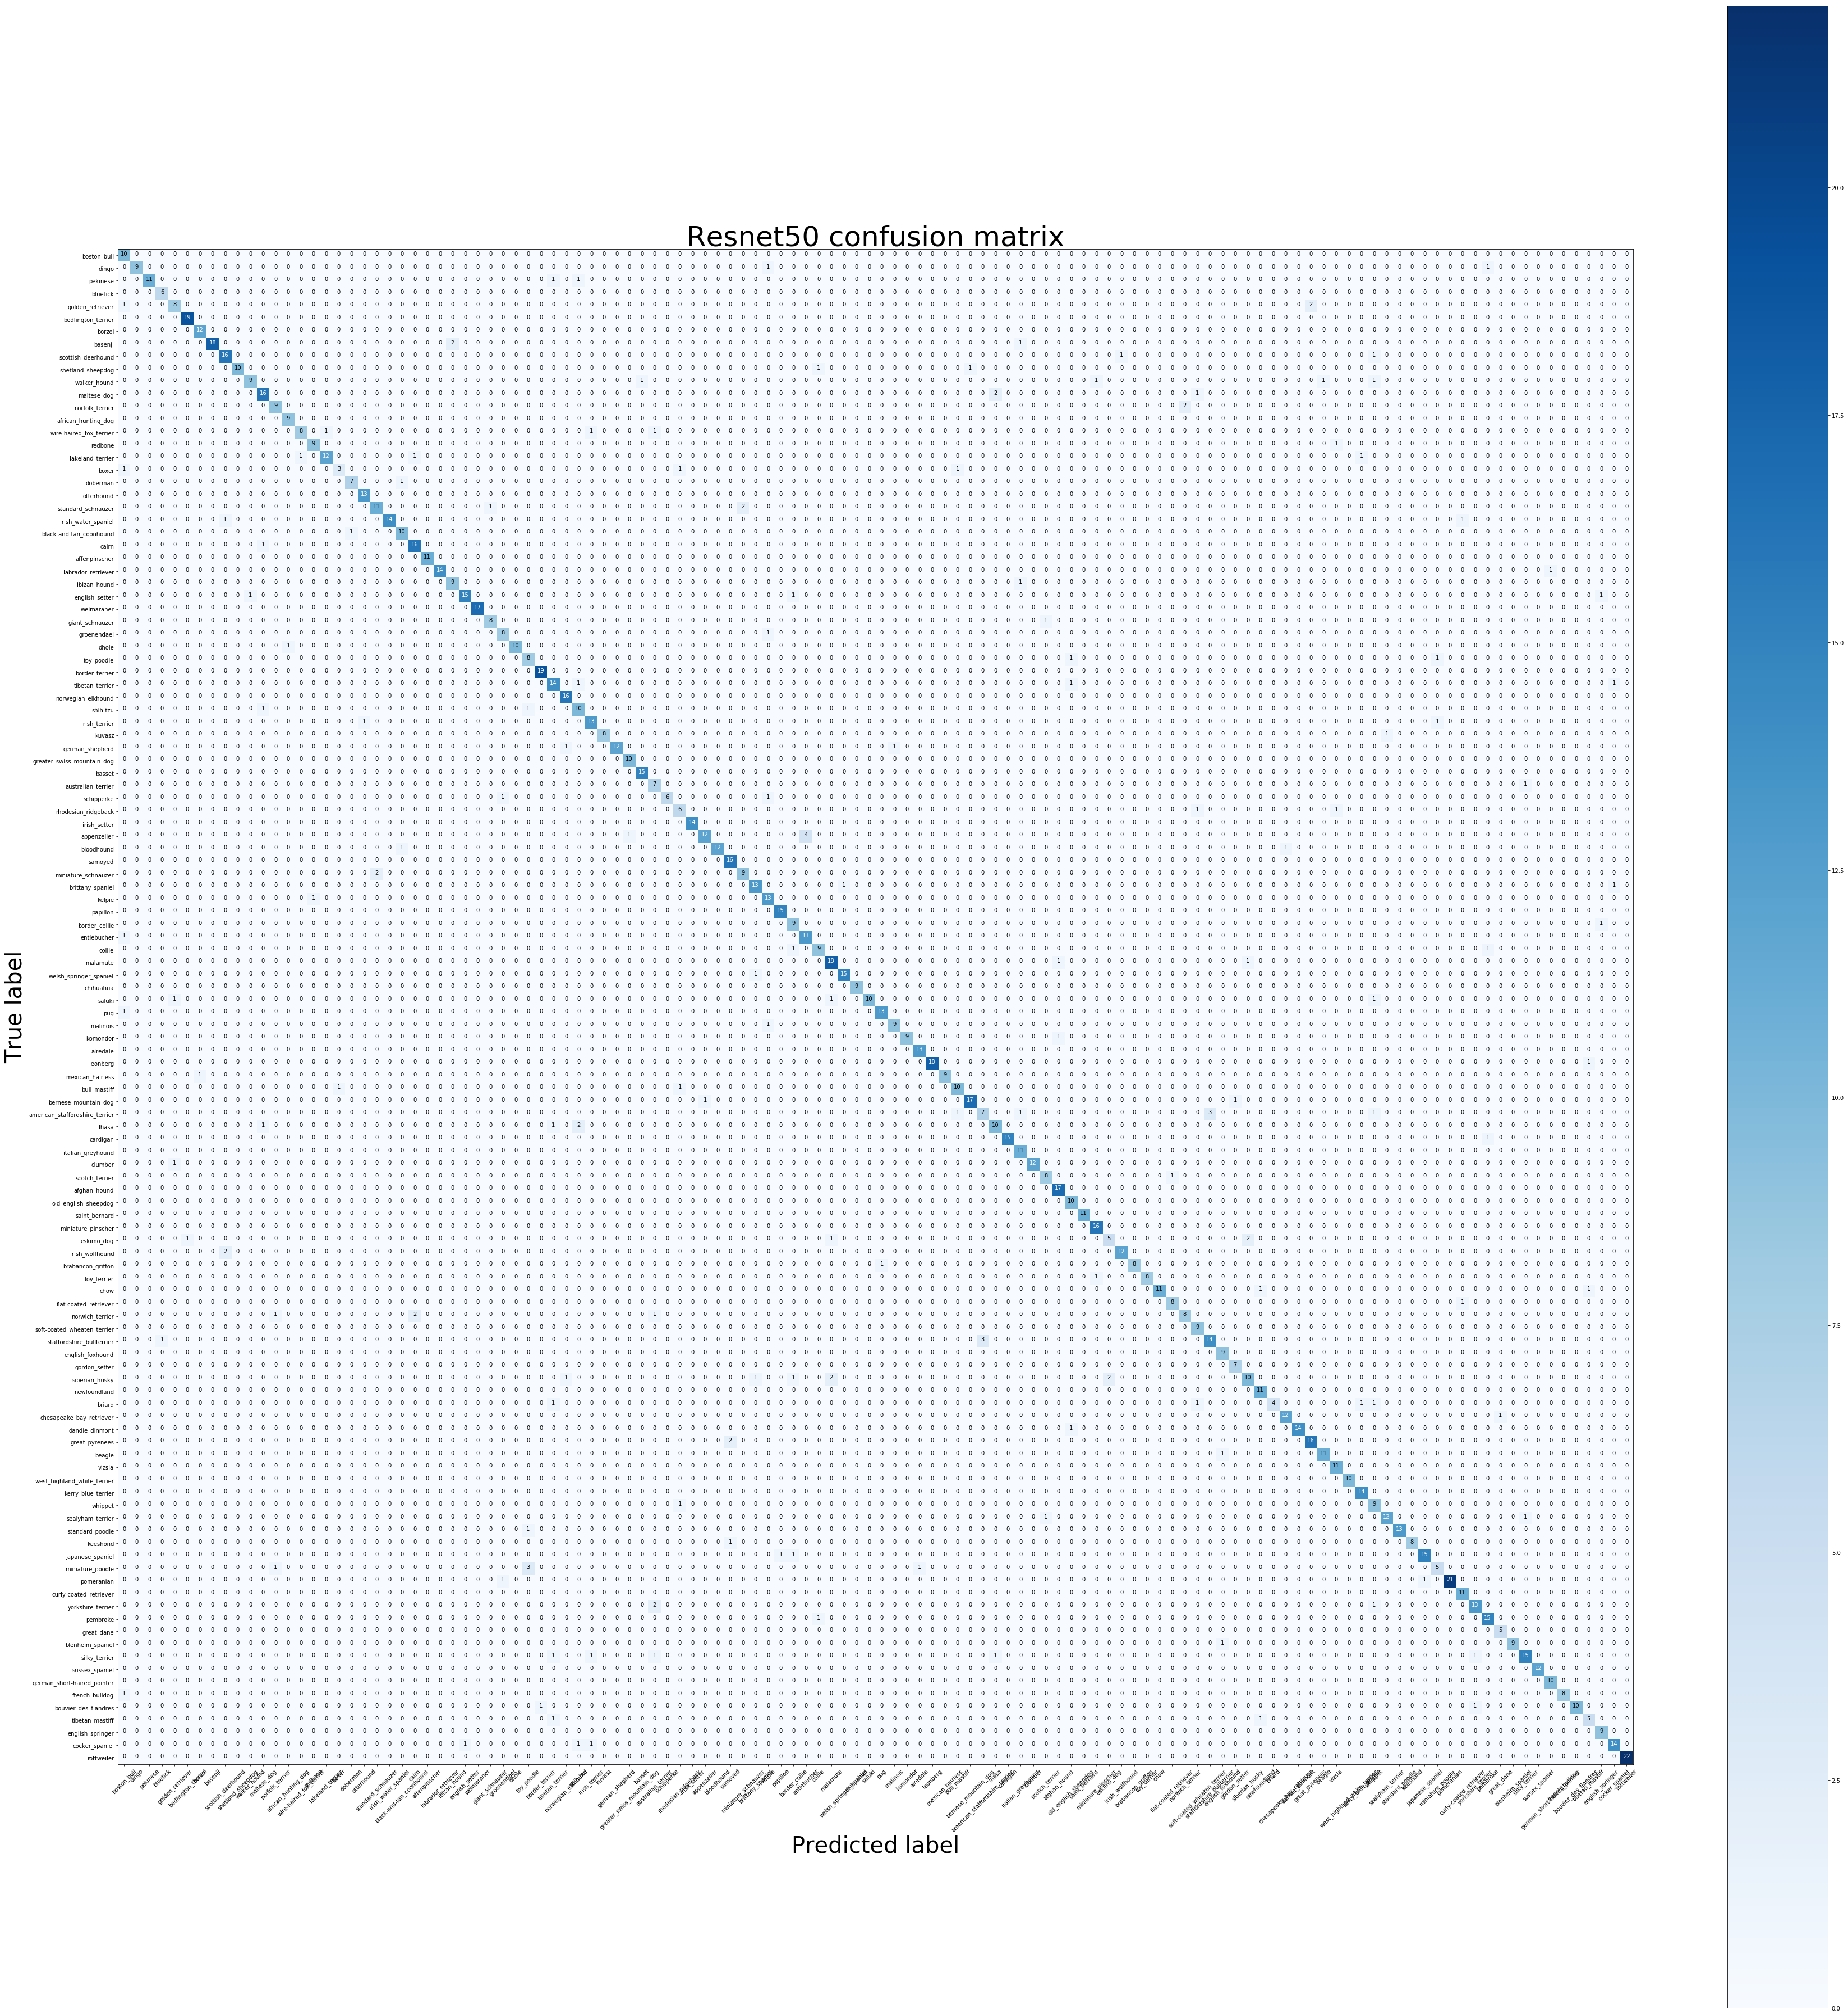

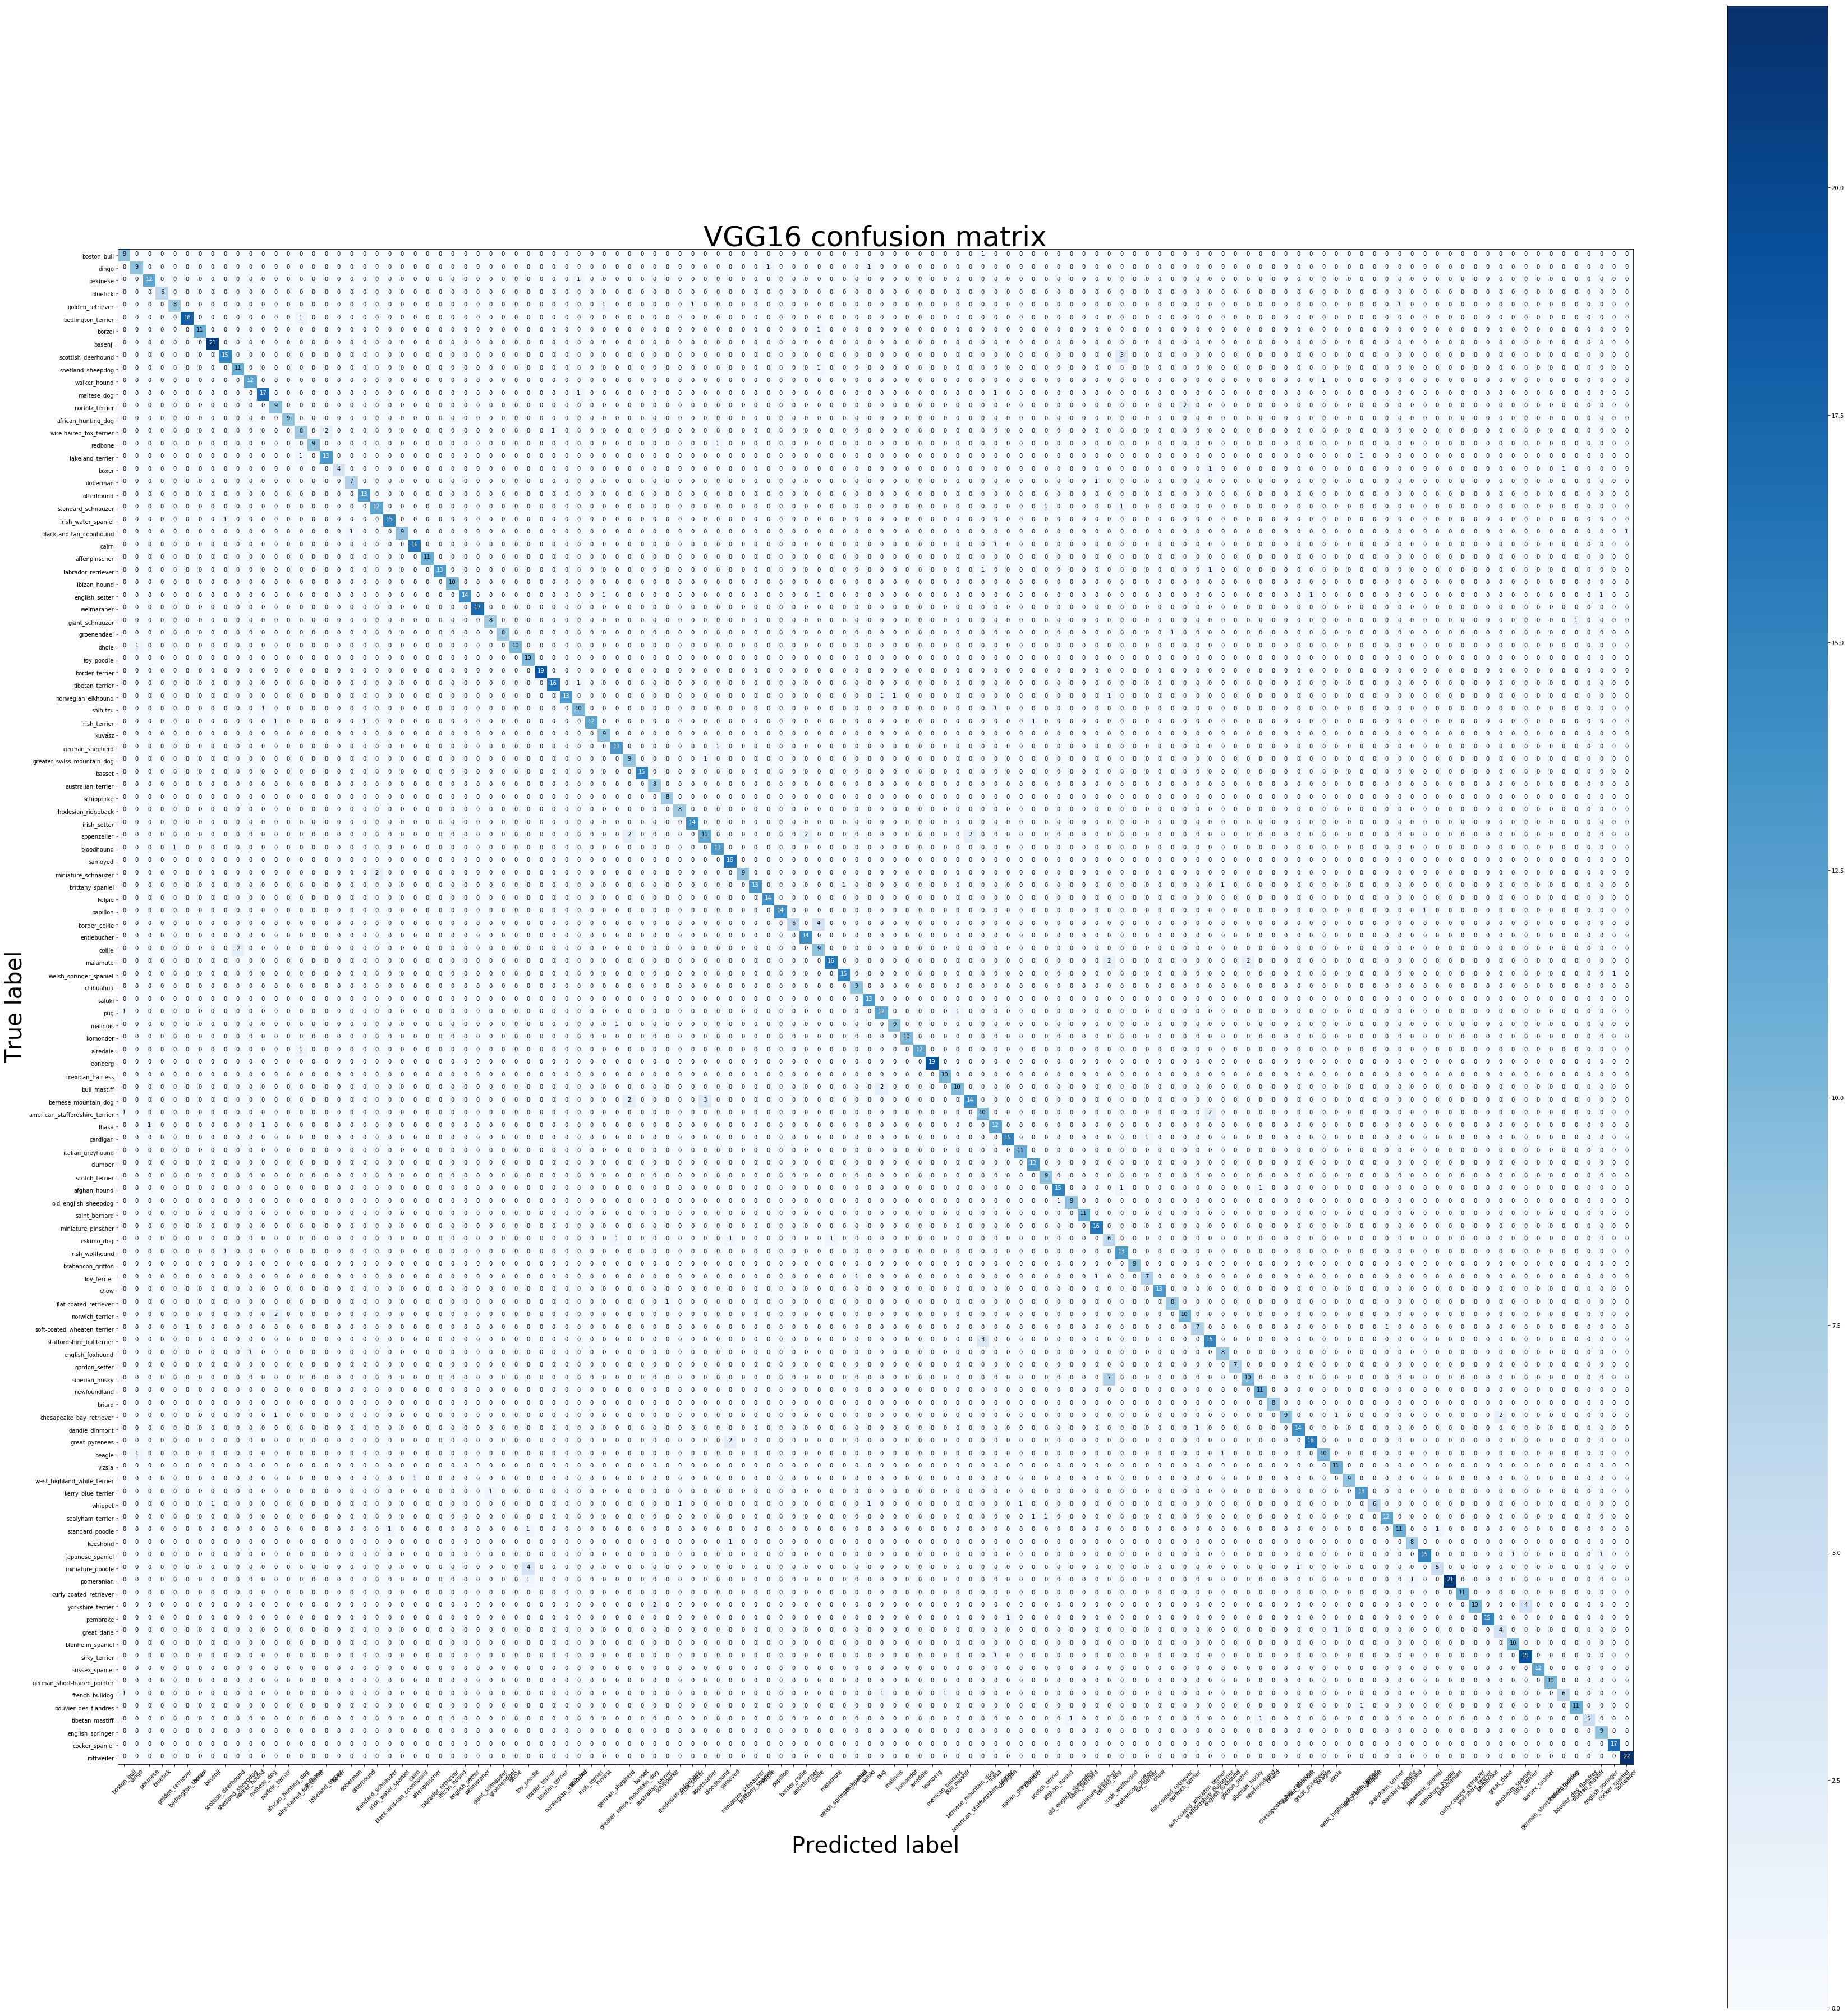

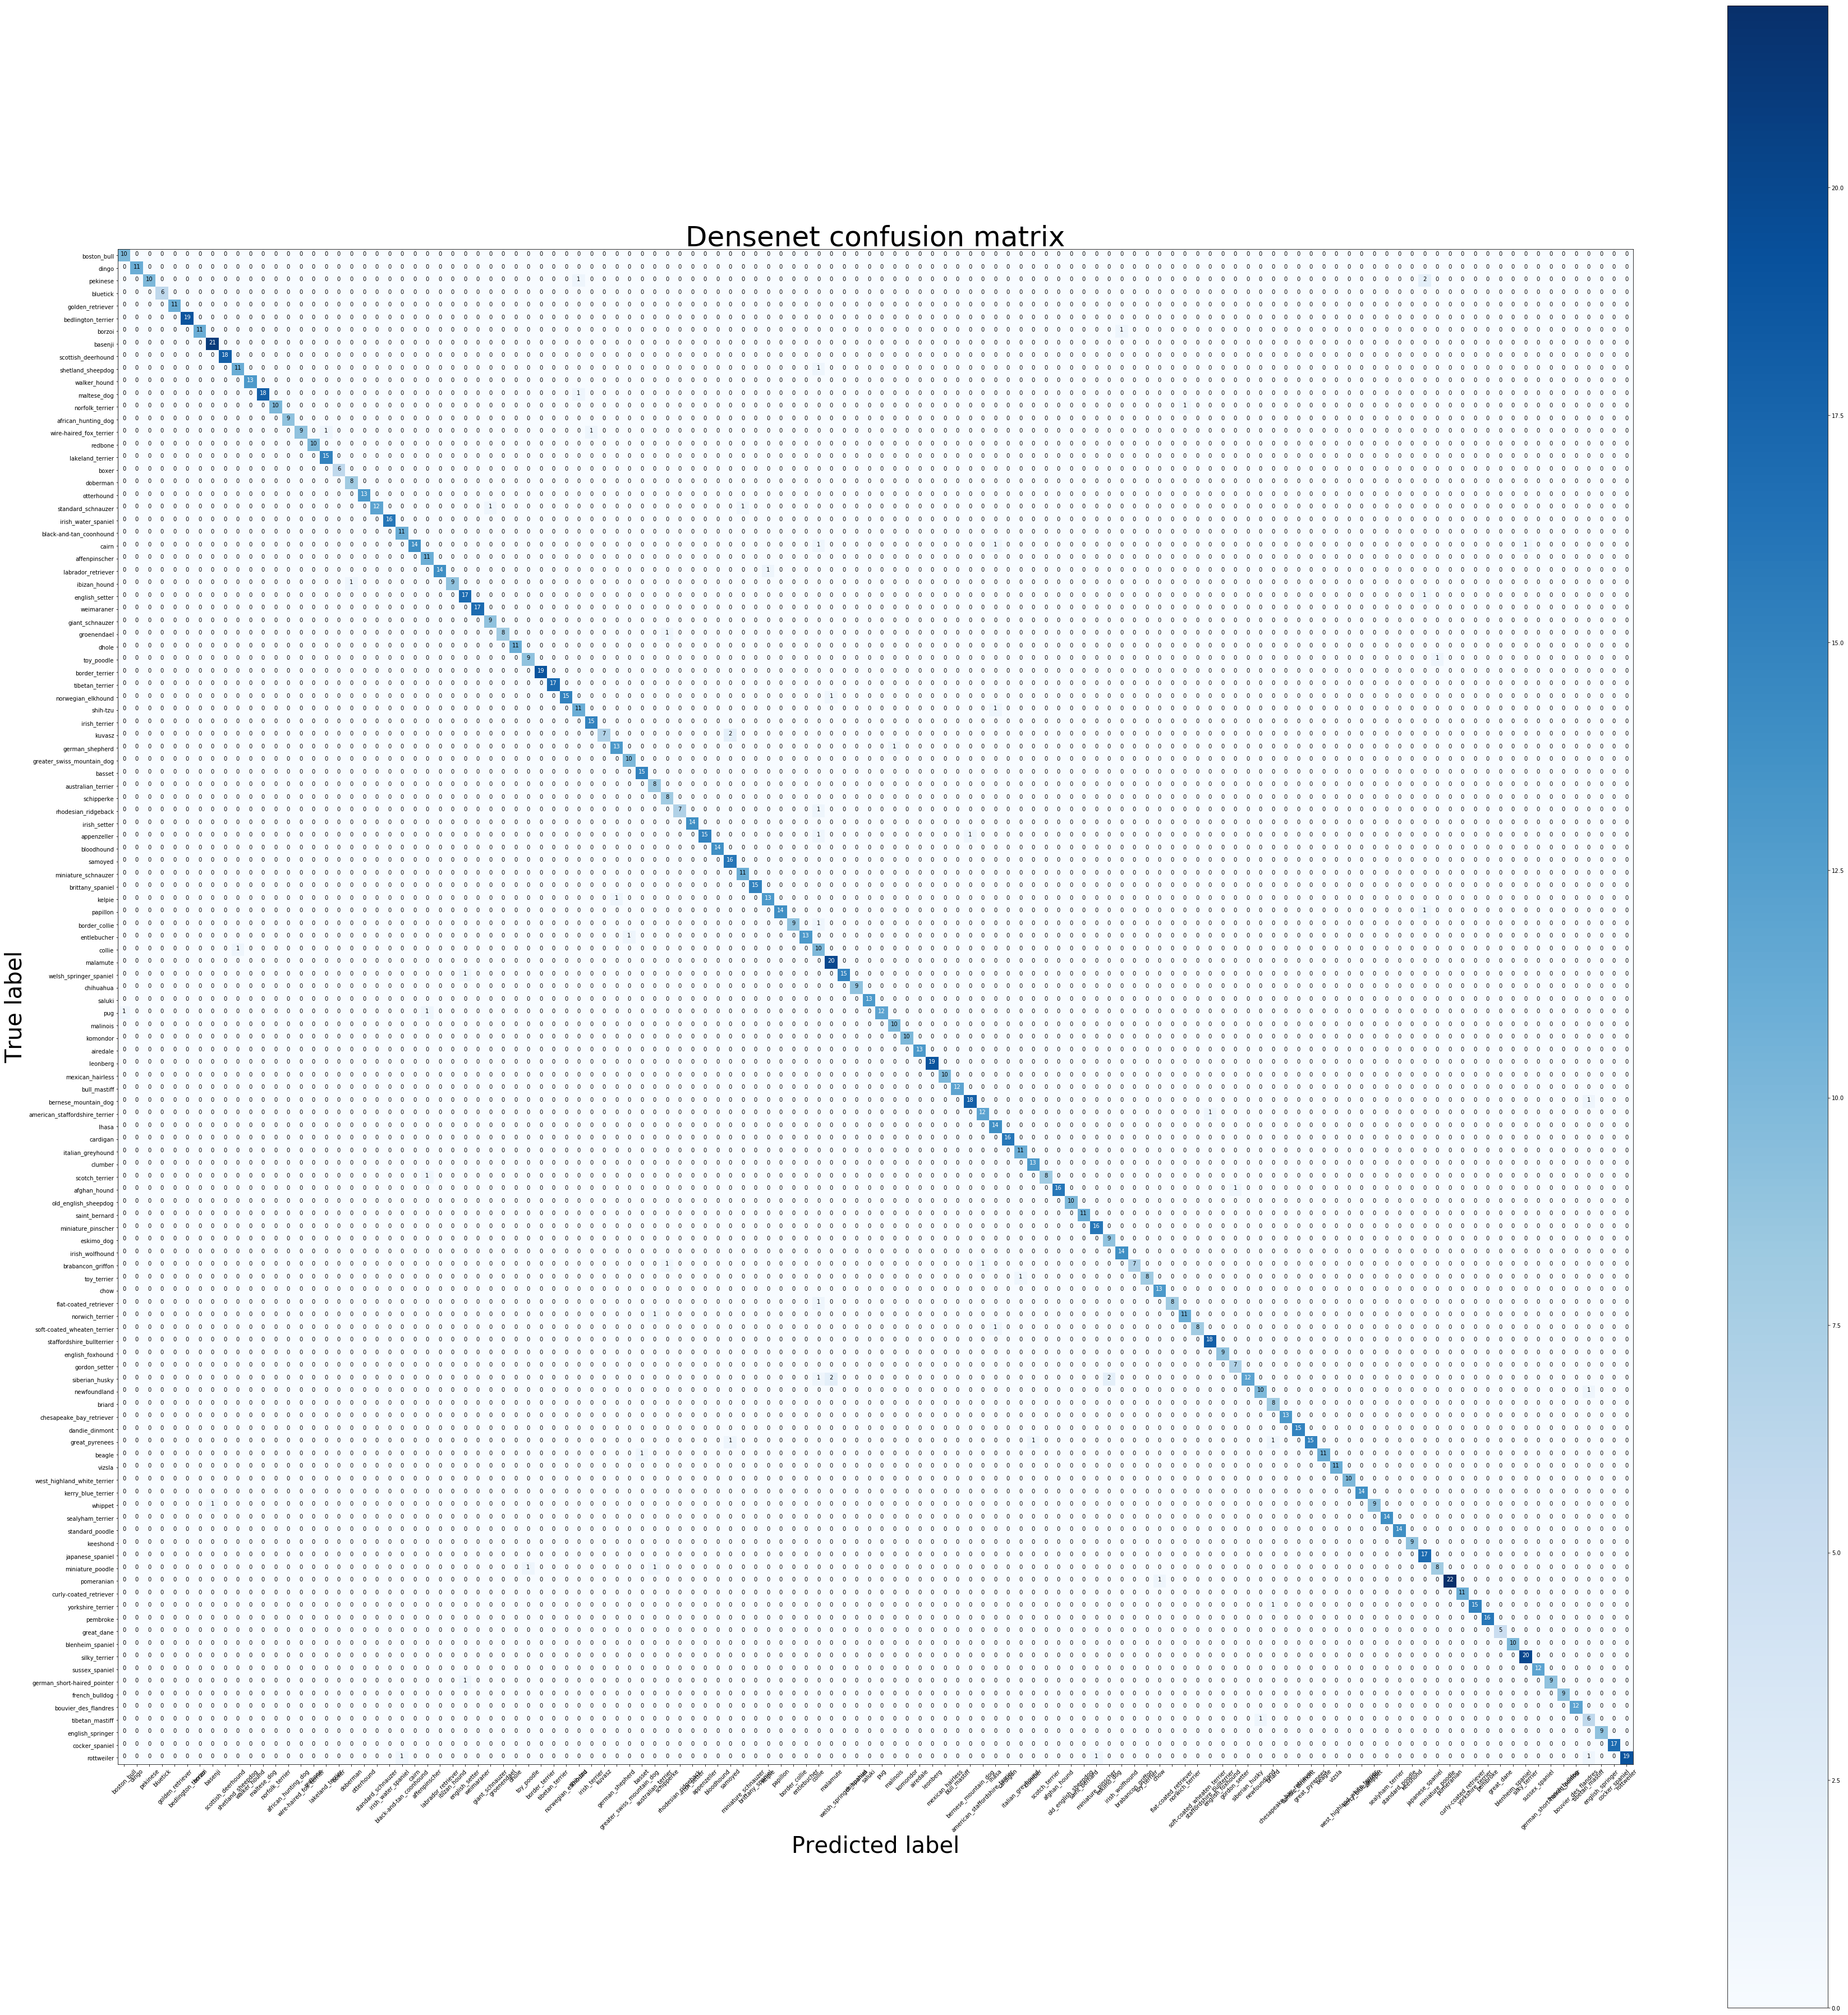

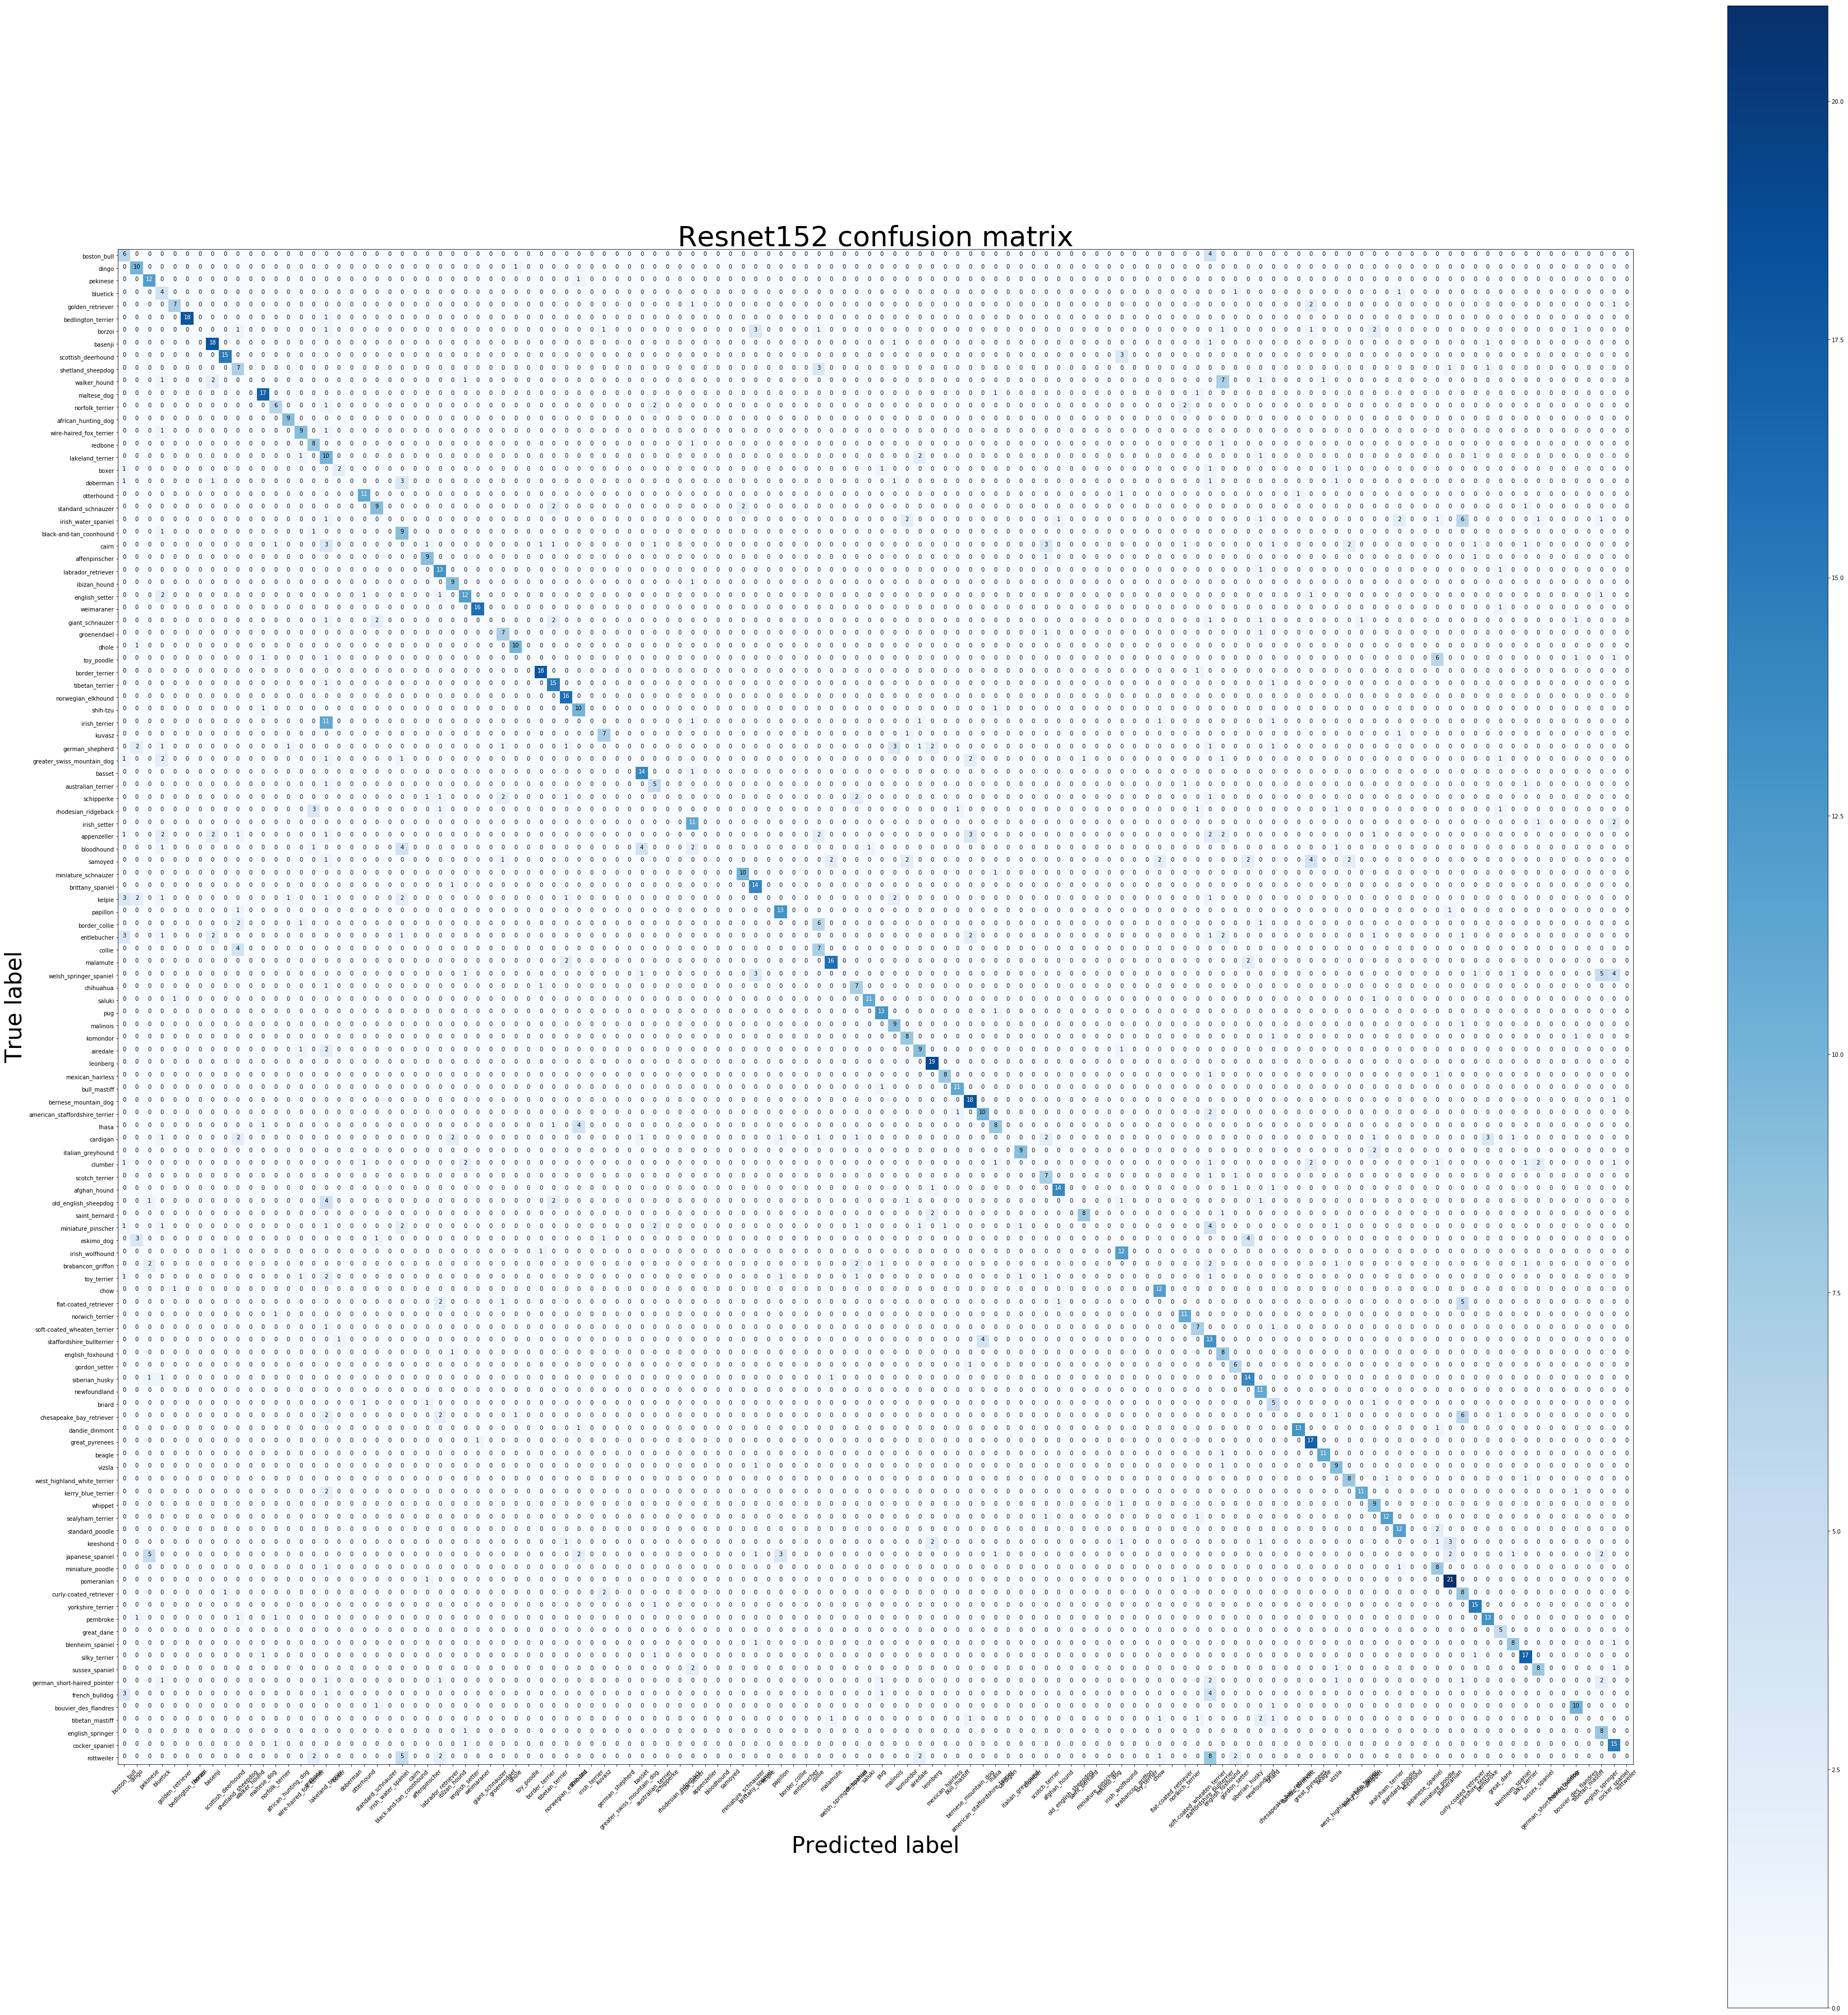

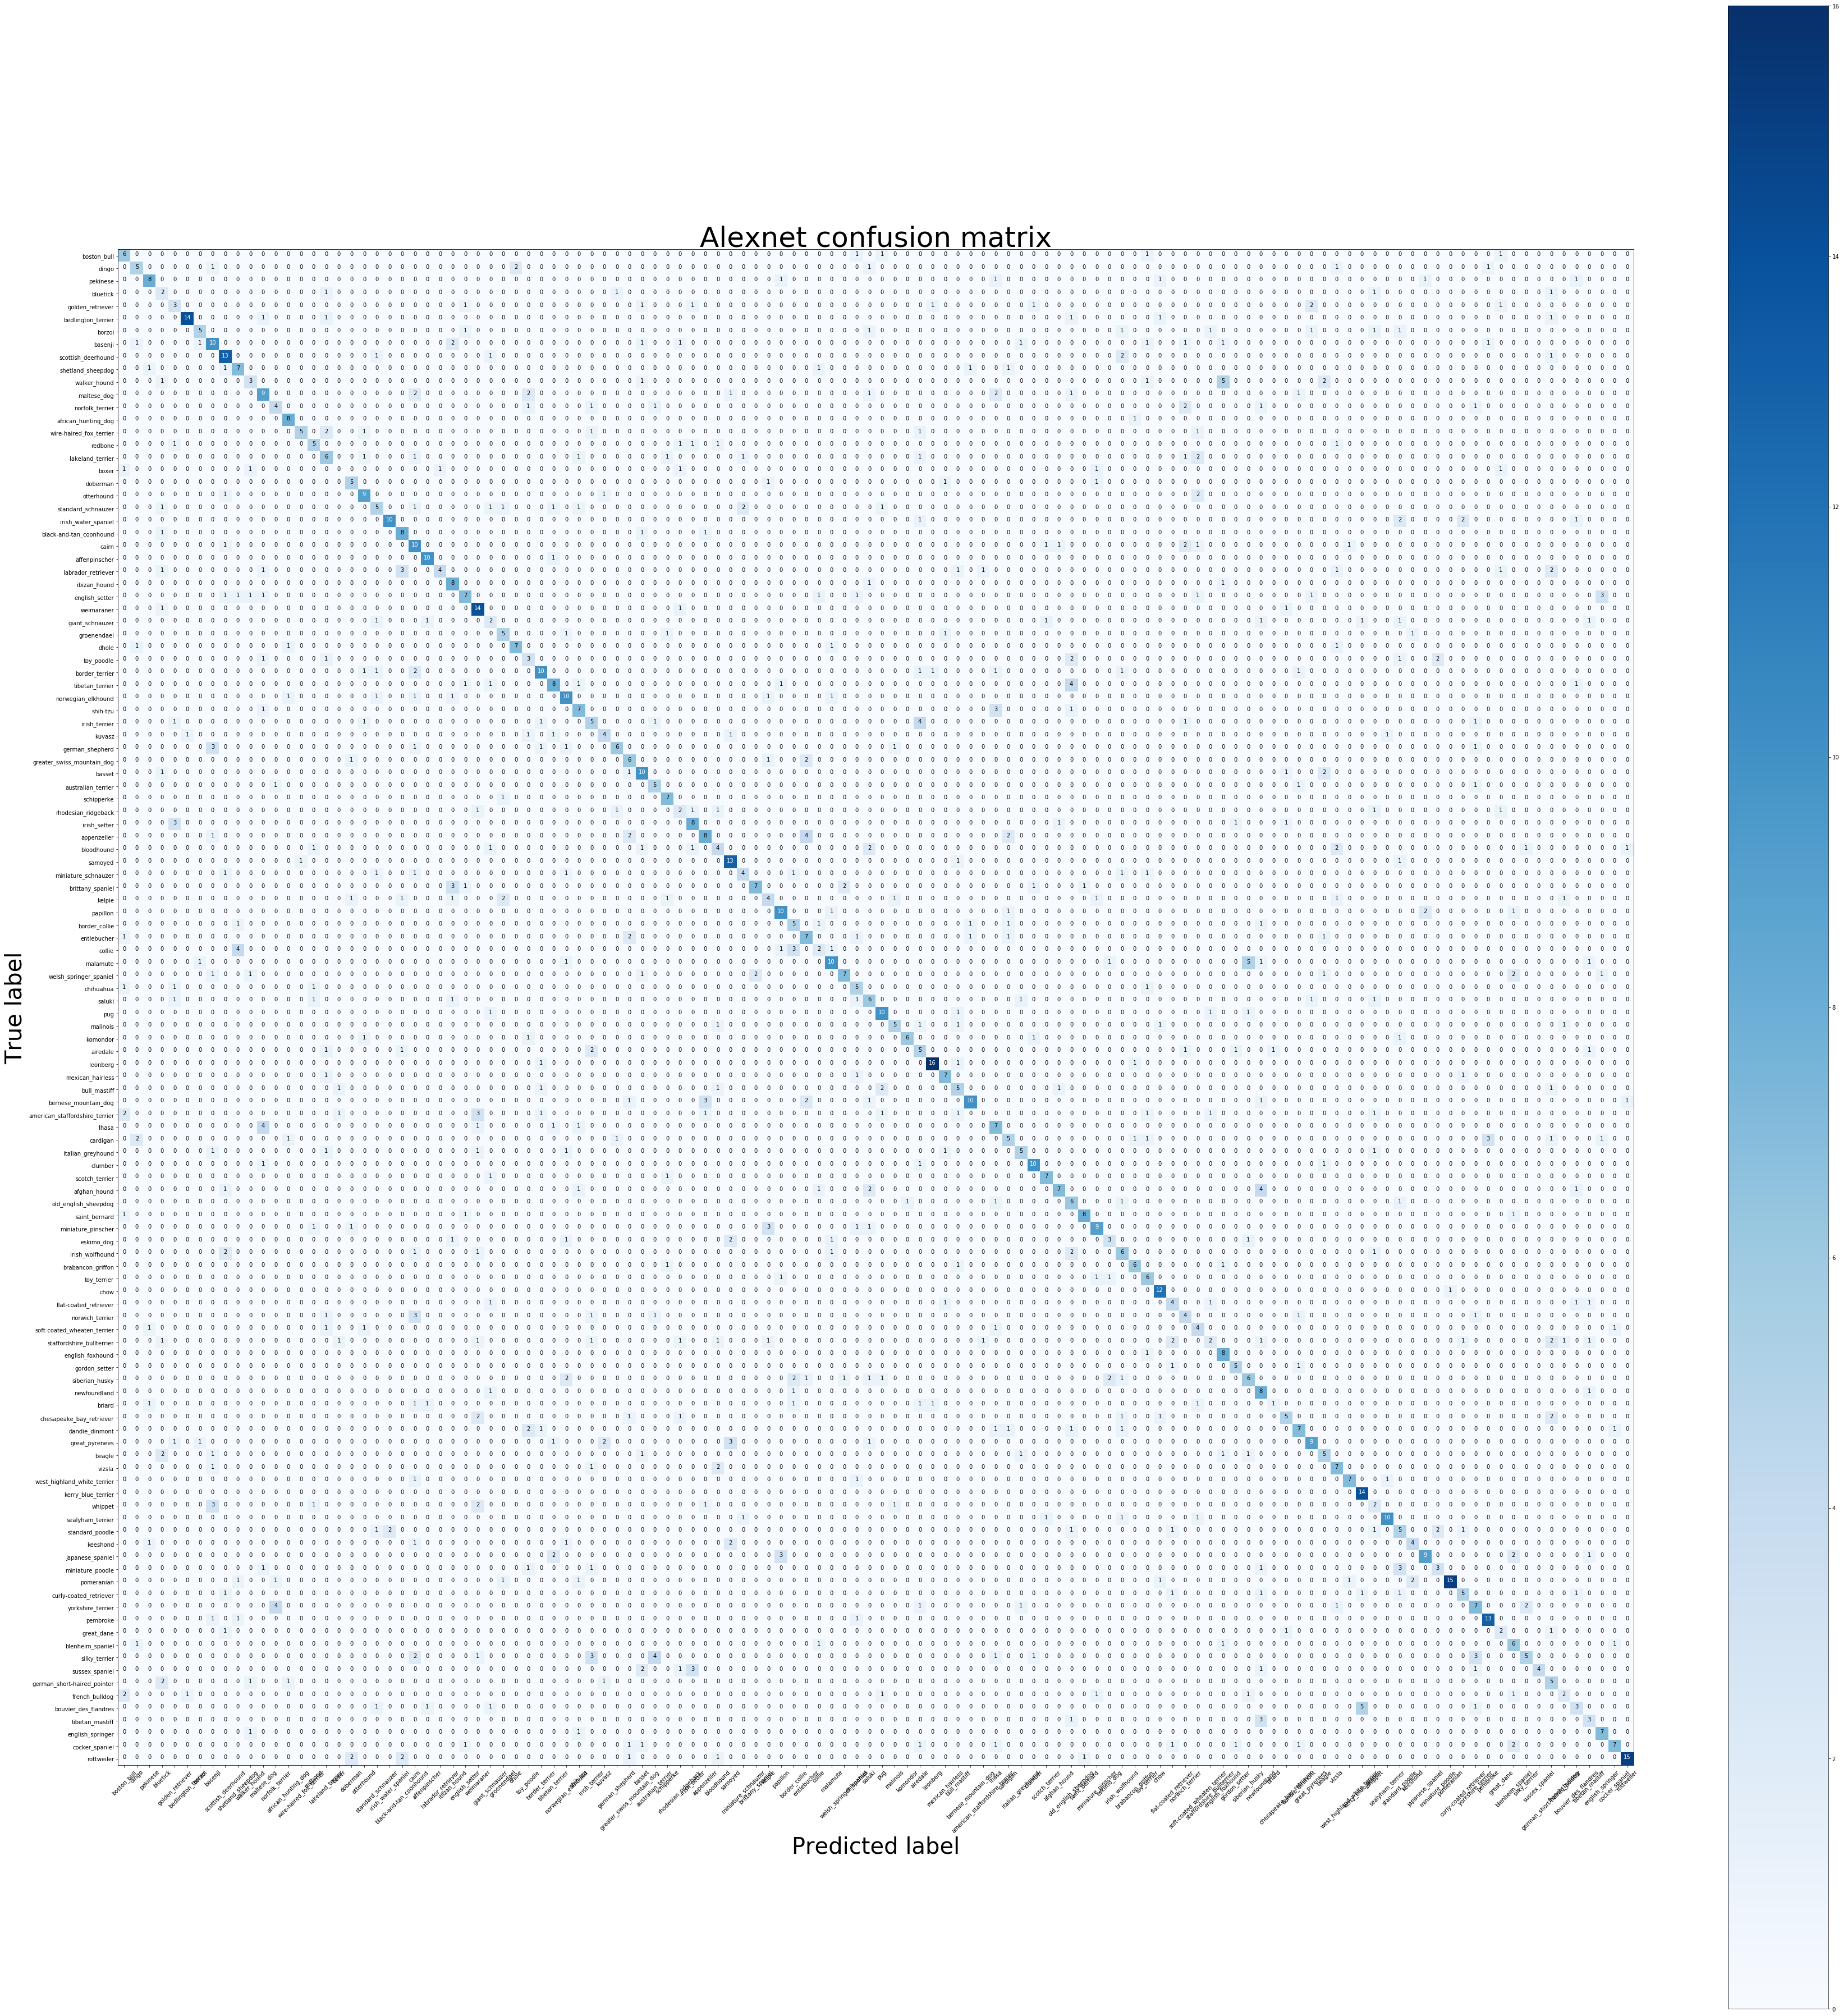

In [9]:
resnet_model = torch.load('resnet50-2.pth')
resnet152_model = torch.load('resnet152.pth')
vgg_model = torch.load('vgg16-2.pth')
densenet_model = torch.load('densenet.pth')
#alexnet_model = torch.load('alexnet.pth')


plot_confusion_matrix(resnet_model, dataloaders["test"], class_names, title="Resnet50 confusion matrix")
plot_confusion_matrix(vgg_model, dataloaders["test"], class_names, title="VGG16 confusion matrix")
plot_confusion_matrix(densenet_model, dataloaders["test"], class_names, title="Densenet confusion matrix")
plot_confusion_matrix(resnet152_model, dataloaders["test"], class_names, title="Resnet152 confusion matrix")
plot_confusion_matrix(alexnet_model, dataloaders["test"], class_names, title="Alexnet confusion matrix")

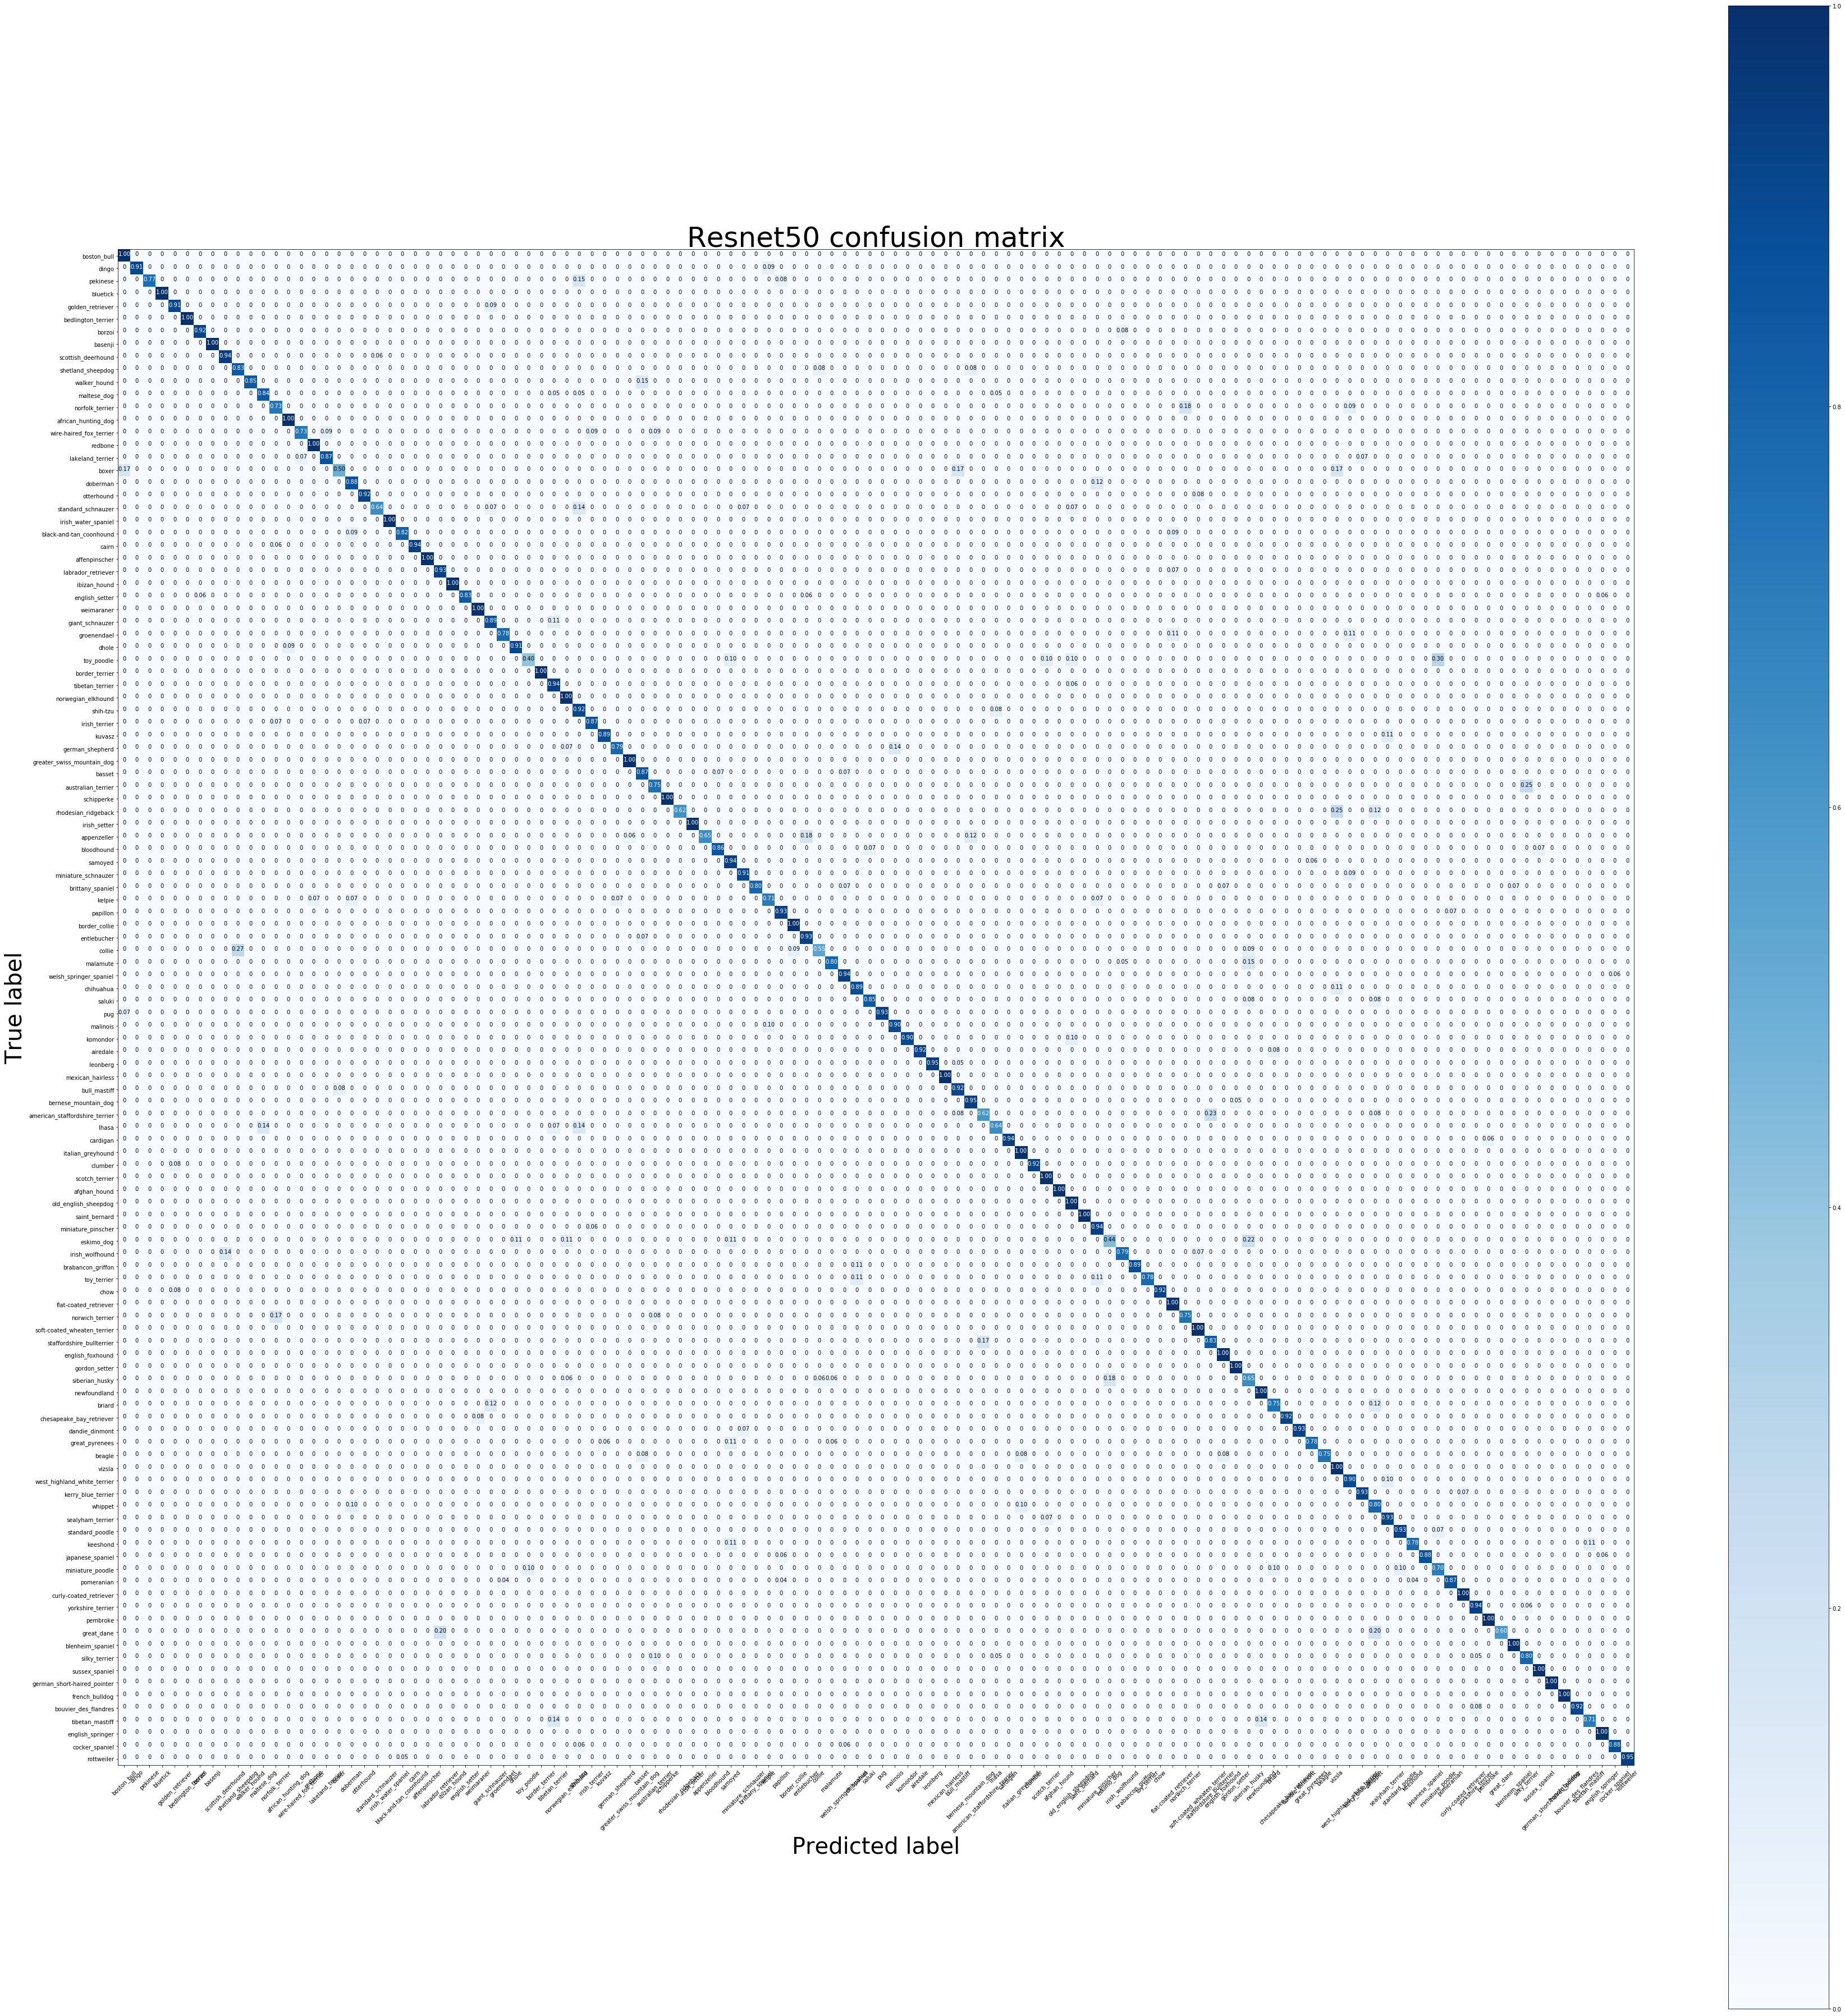

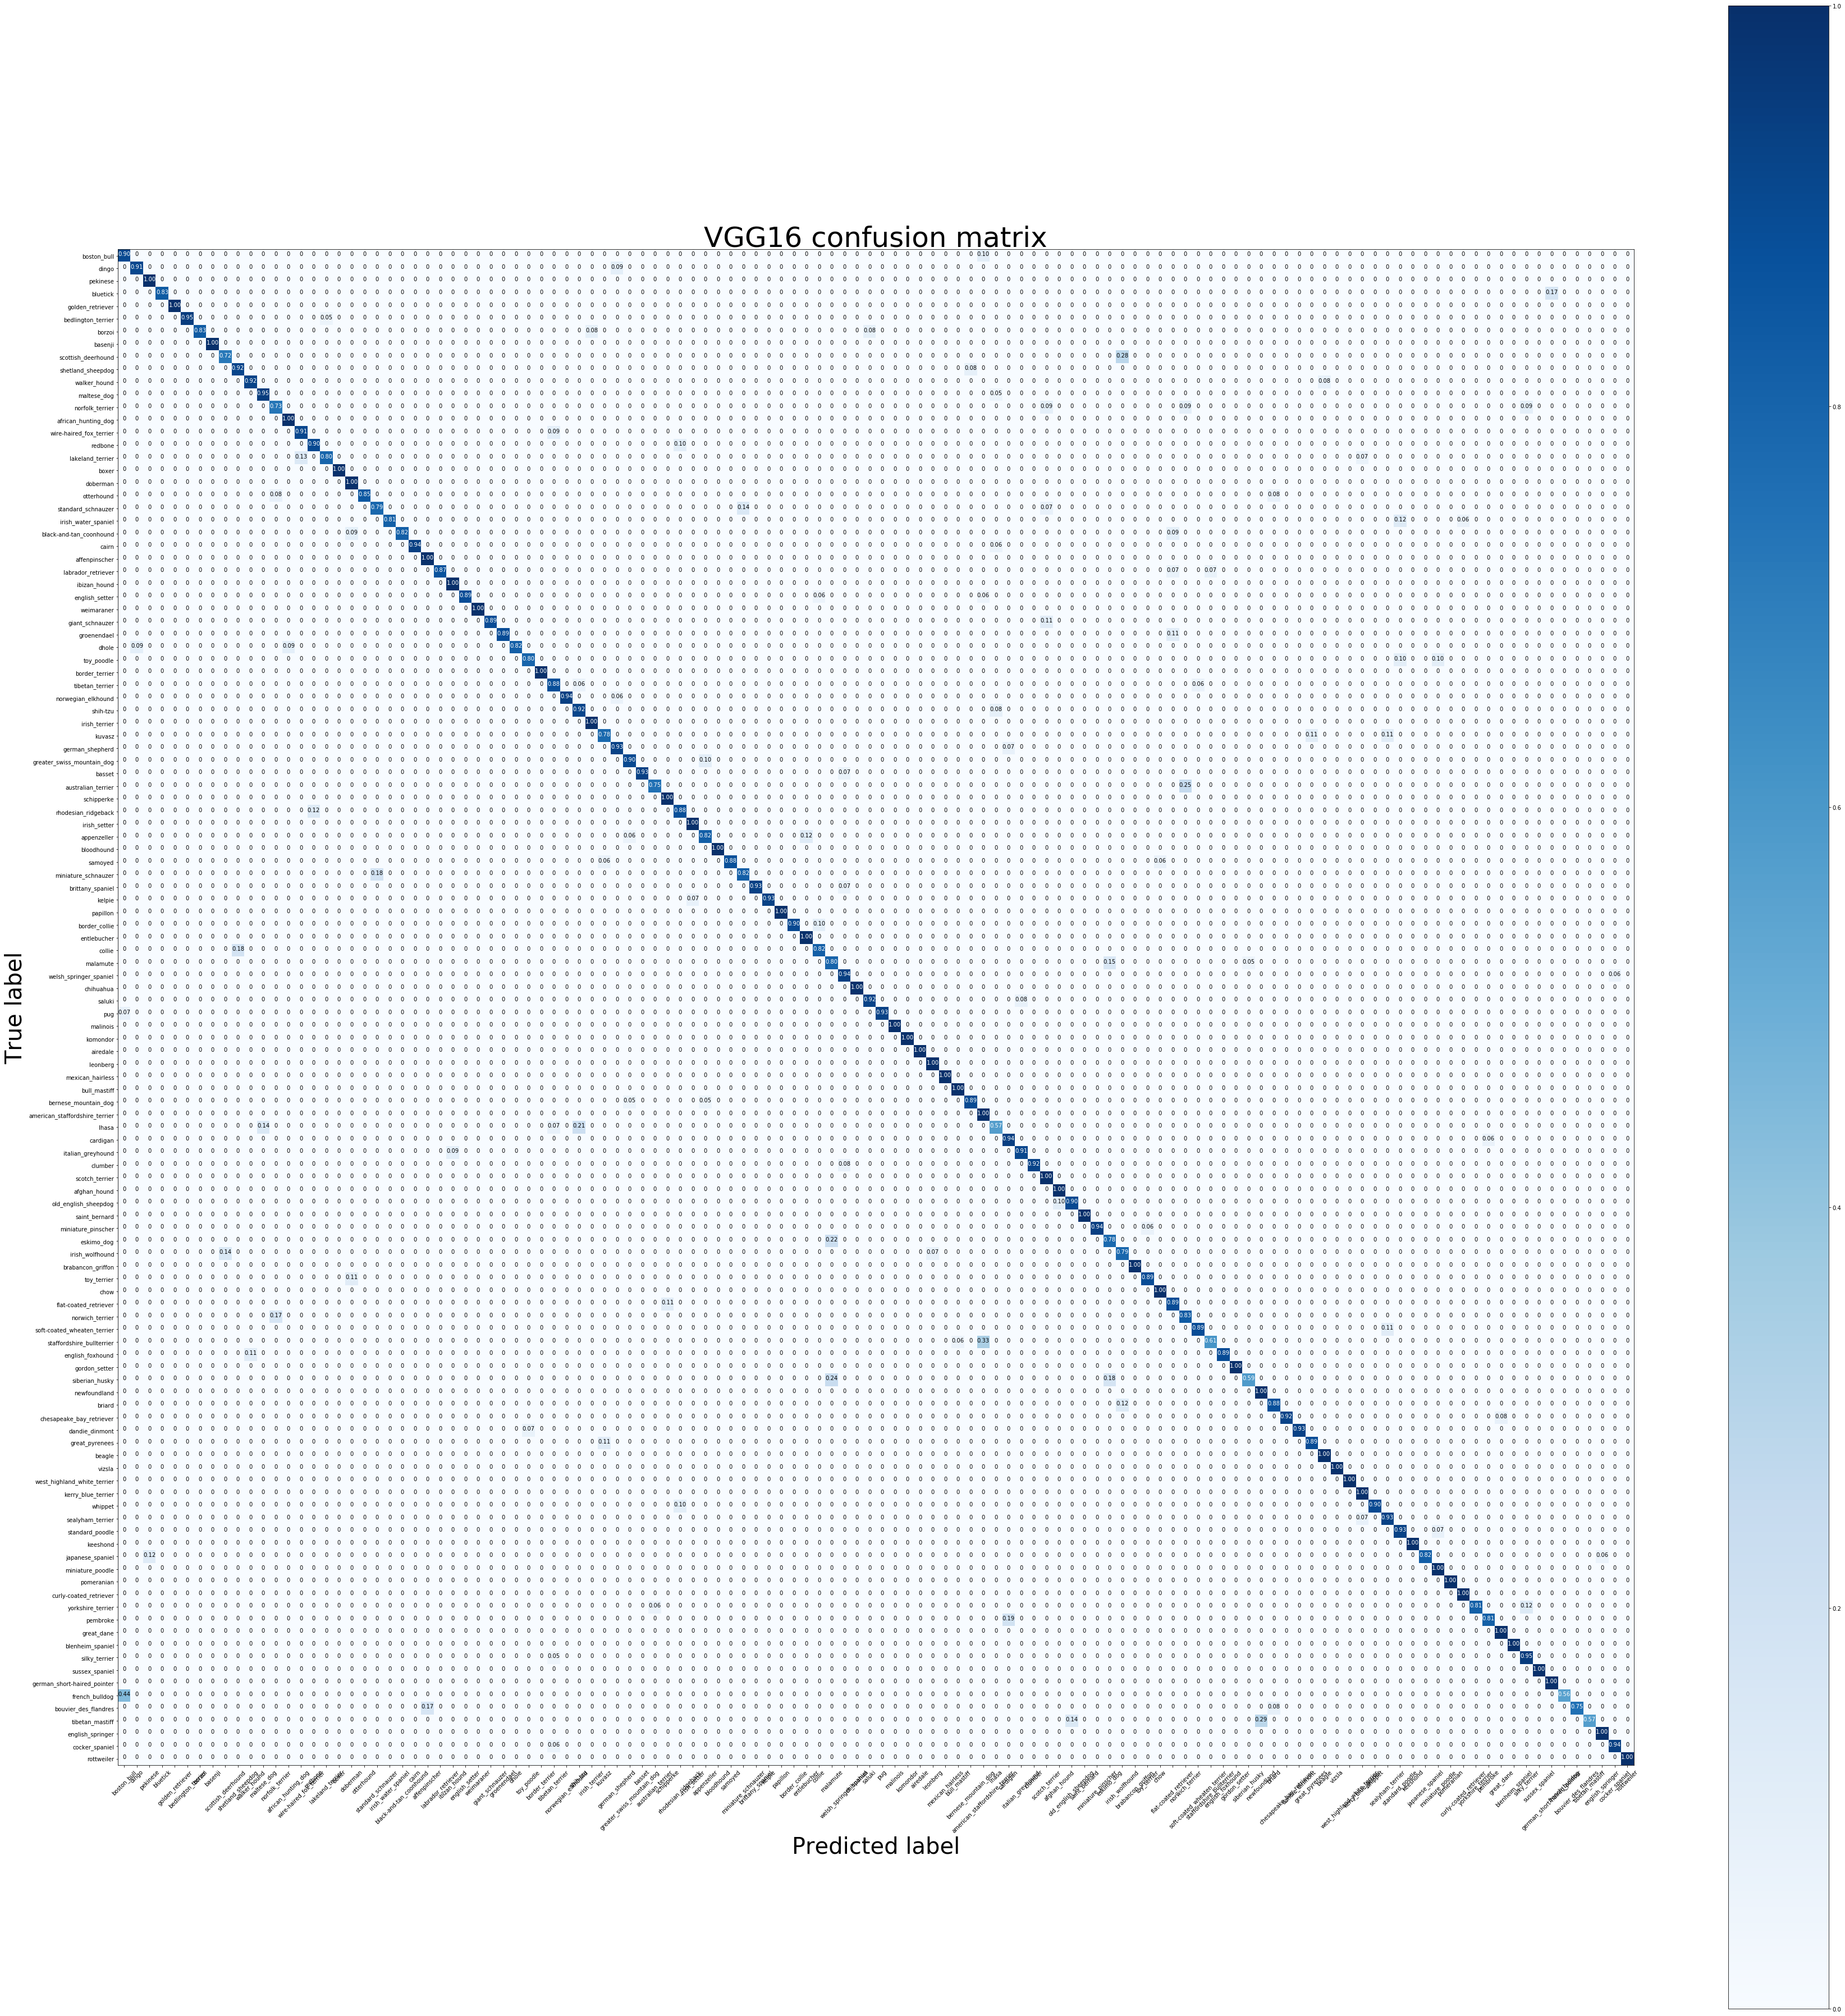

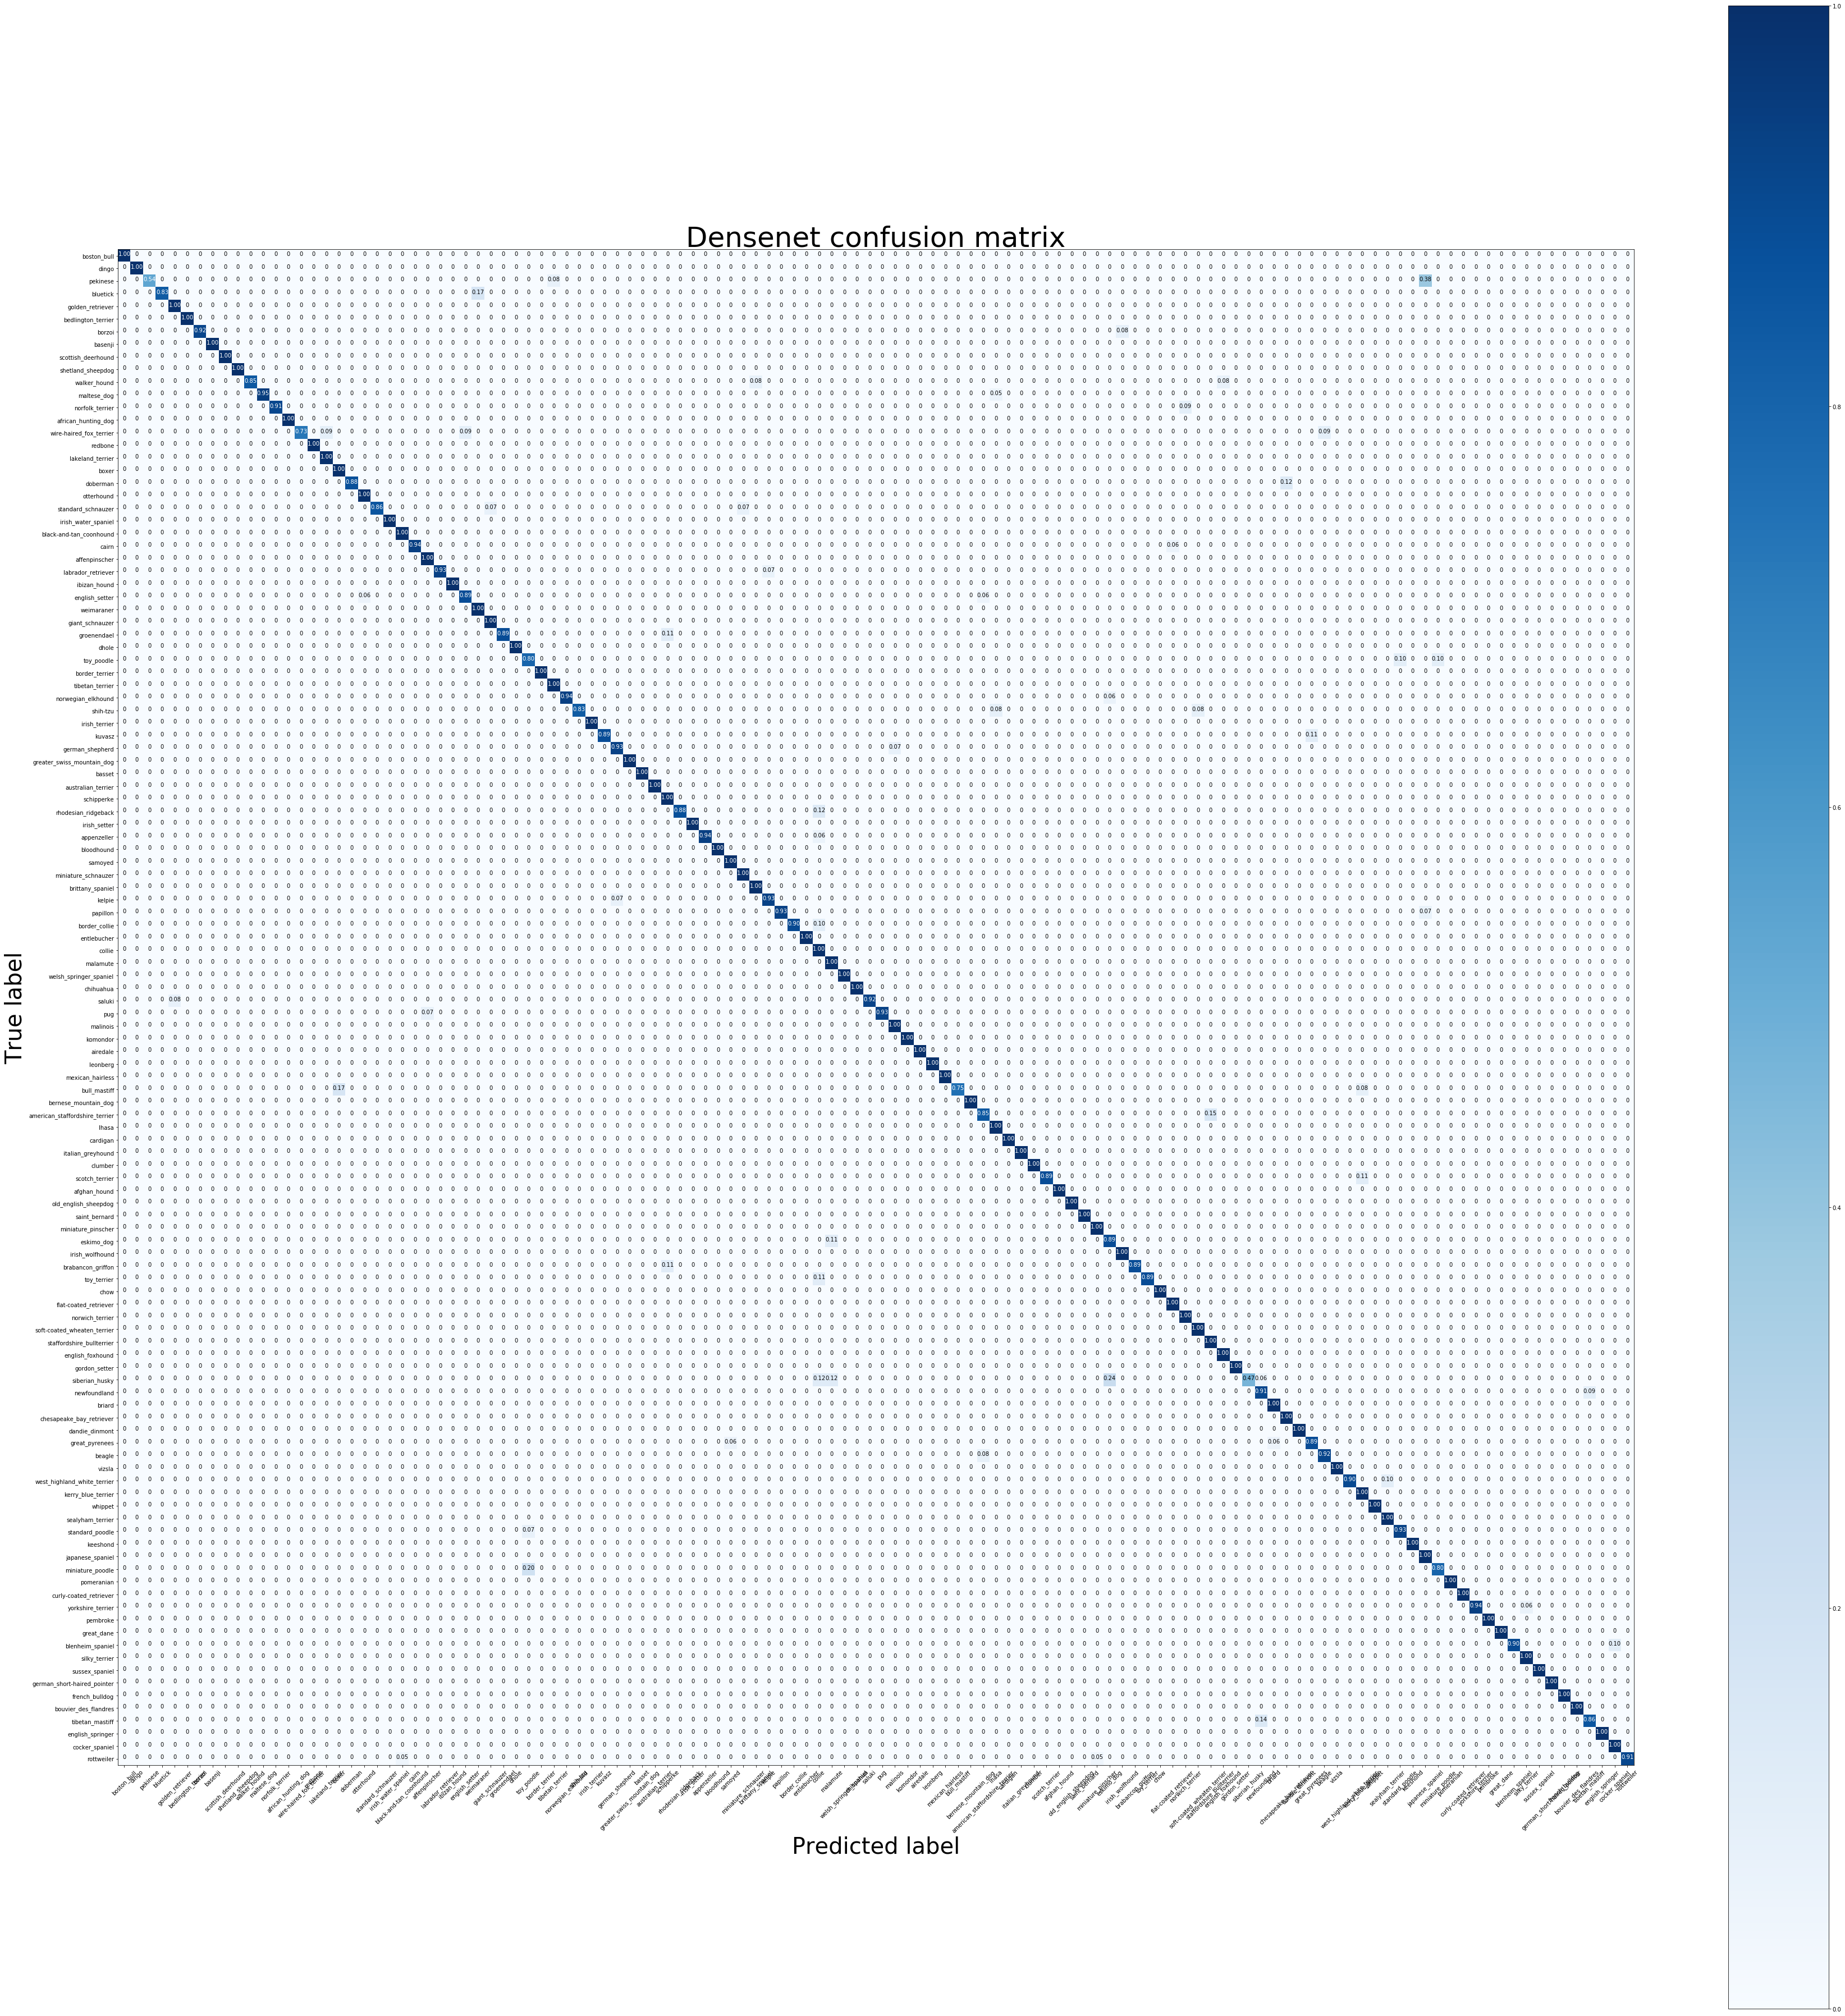

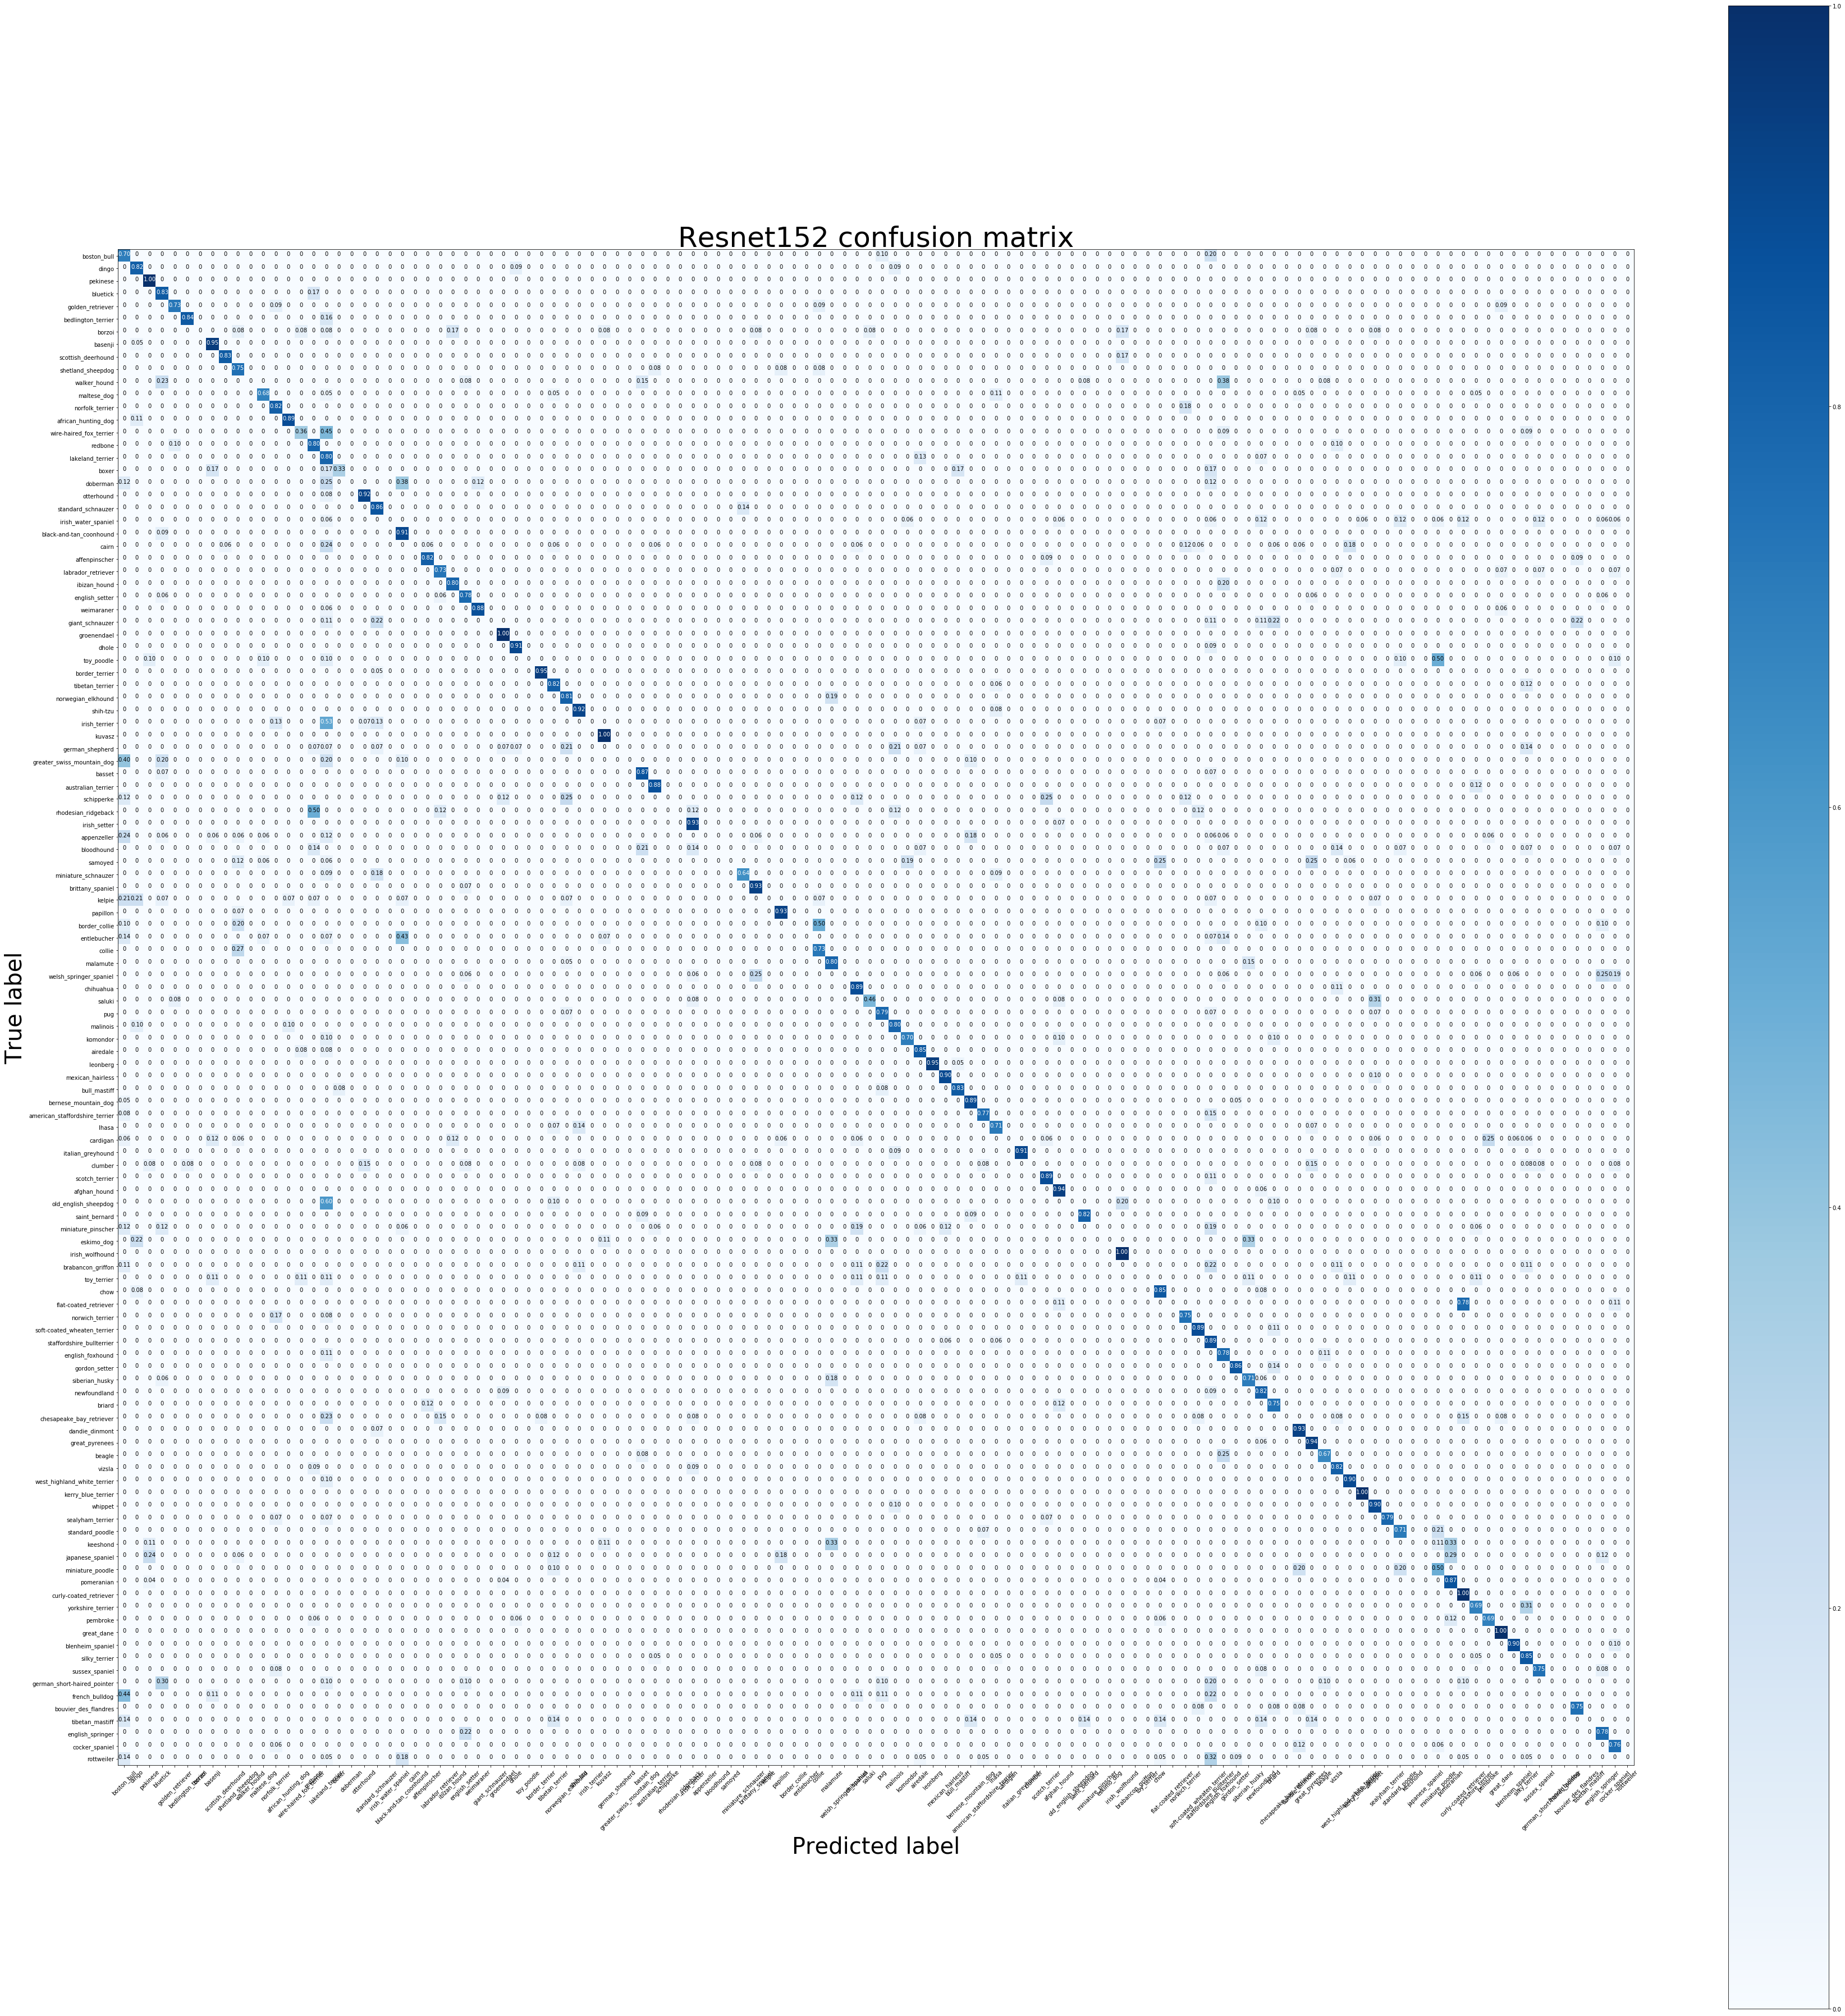

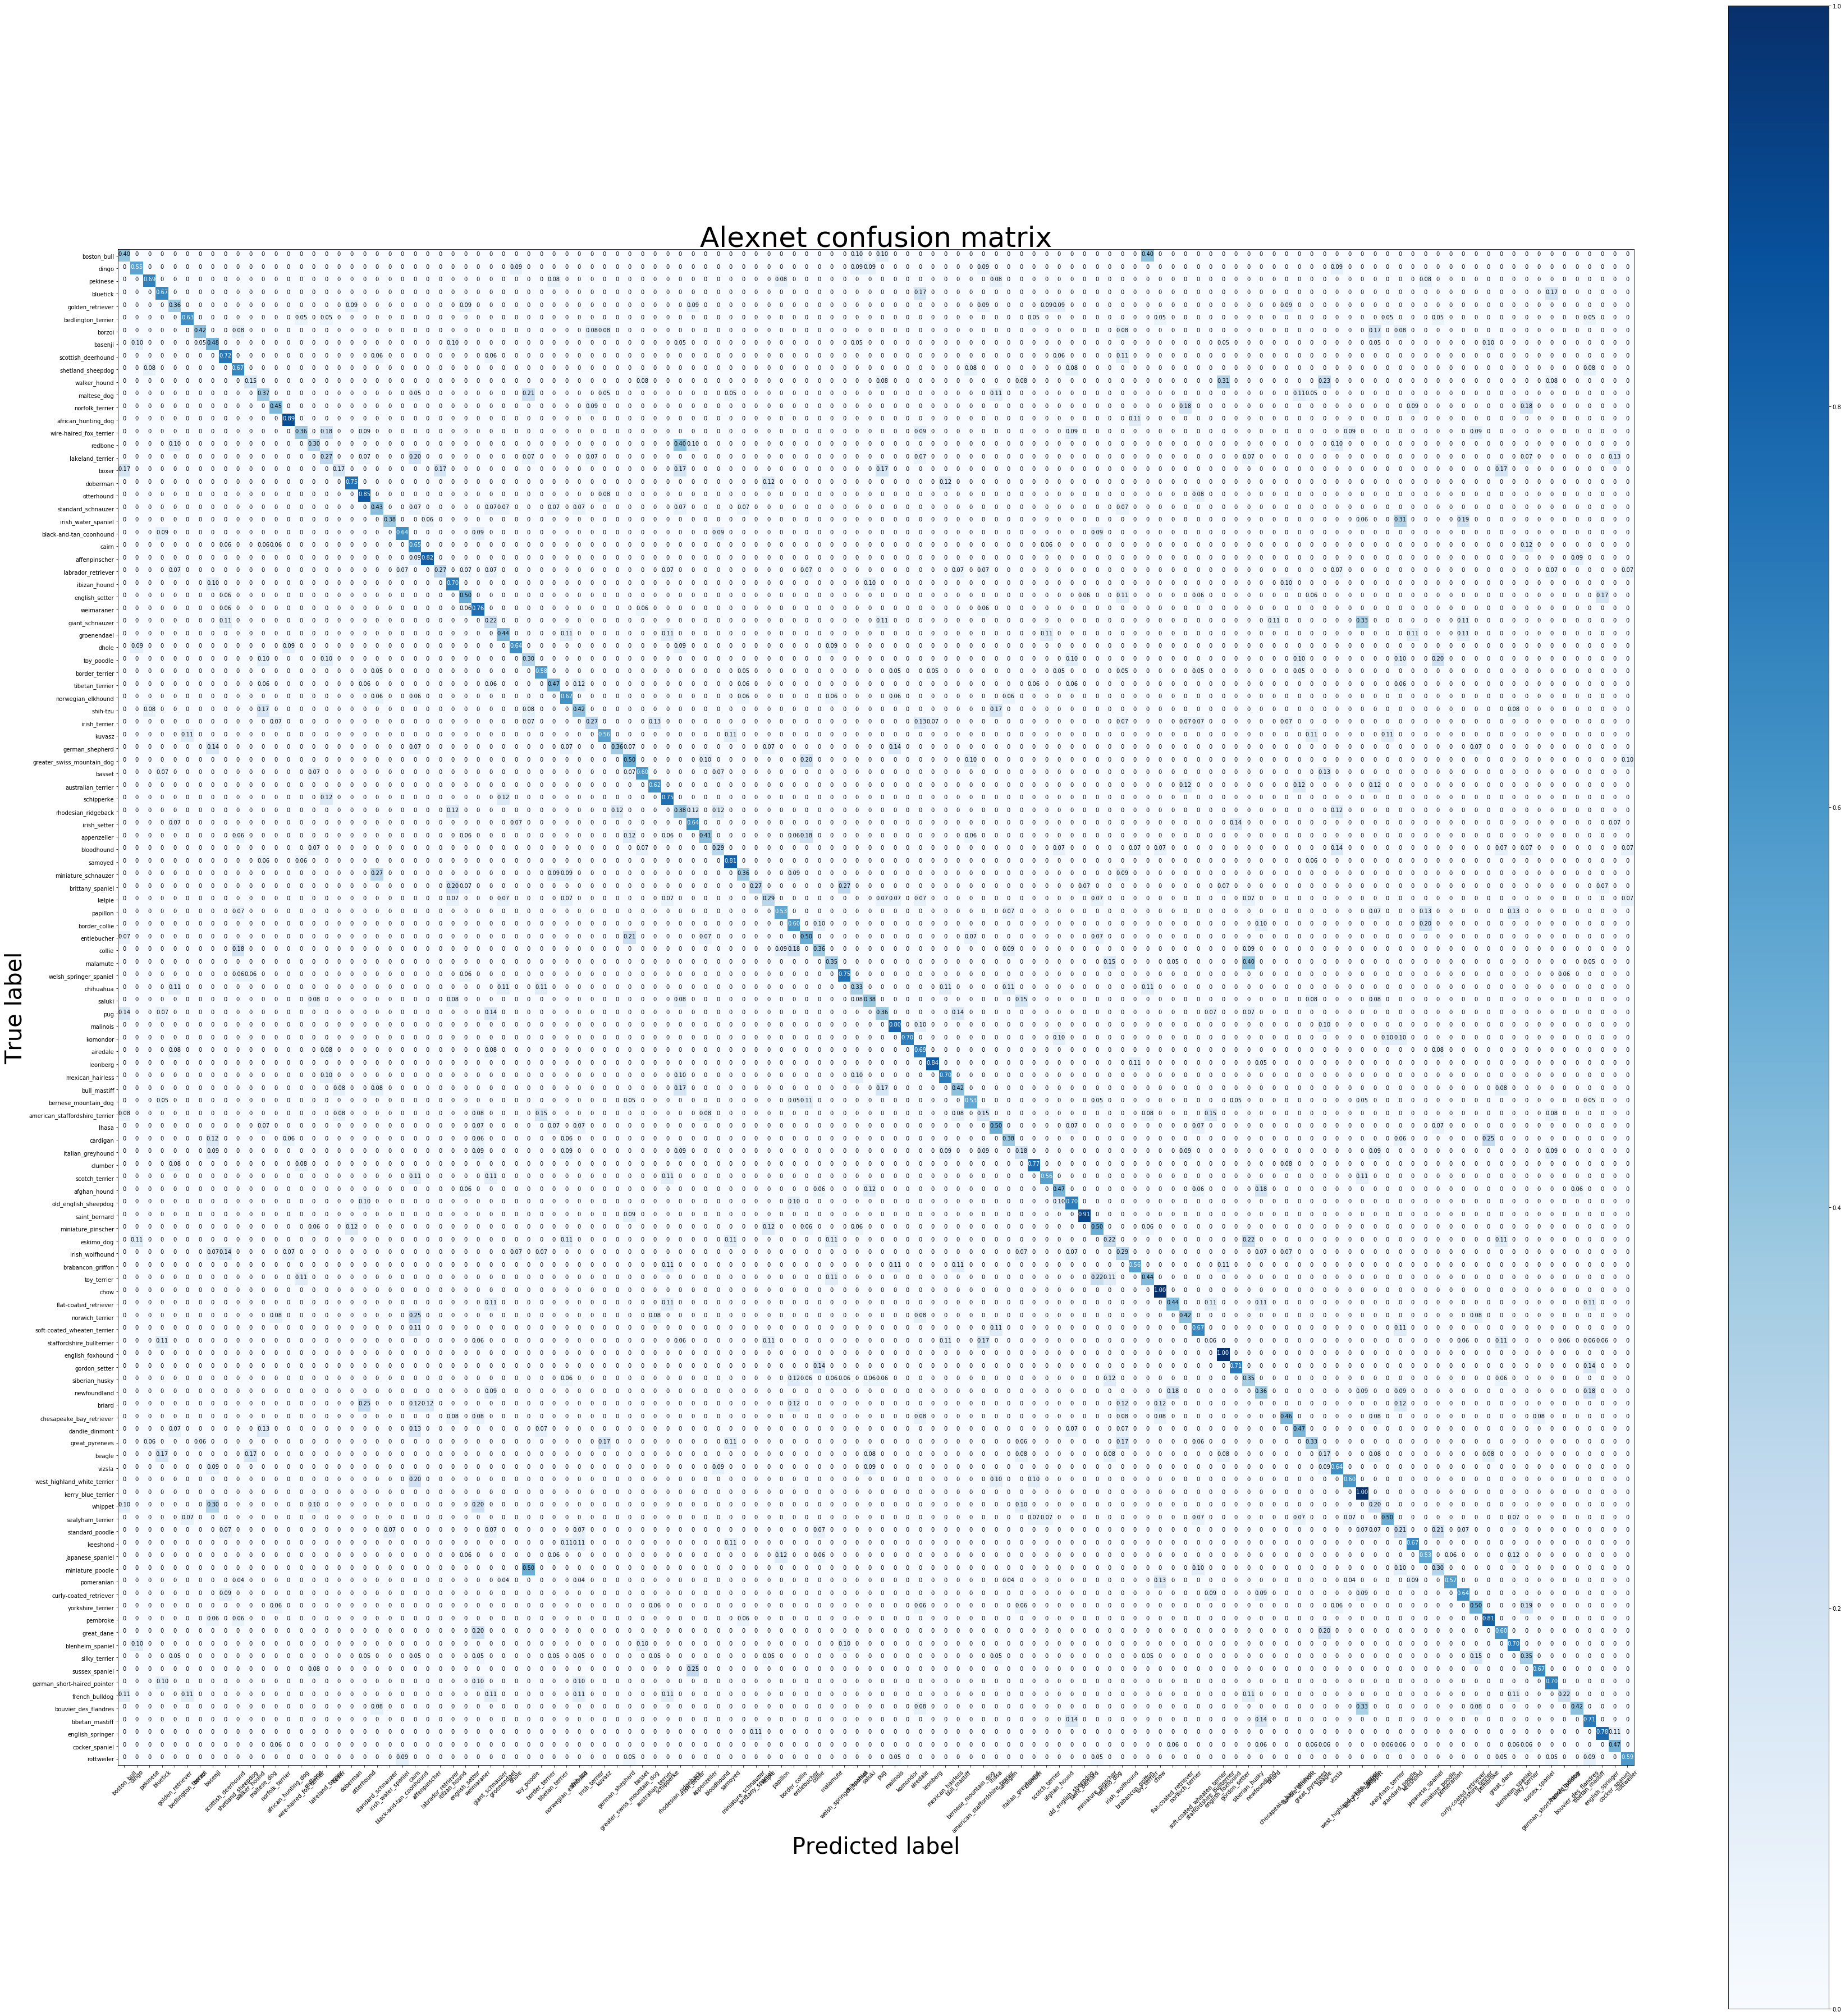

In [21]:
plot_confusion_matrix(resnet_model, dataloaders["test"], class_names, normalize=True, title="Resnet50 confusion matrix")
plot_confusion_matrix(vgg_model, dataloaders["test"], class_names, normalize=True, title="VGG16 confusion matrix")
plot_confusion_matrix(densenet_model, dataloaders["test"], class_names, normalize=True, title="Densenet confusion matrix")
plot_confusion_matrix(resnet152_model, dataloaders["test"], class_names, normalize=True, title="Resnet152 confusion matrix")
plot_confusion_matrix(alexnet_model, dataloaders["test"], class_names, normalize=True, title="Alexnet confusion matrix")

In [48]:
def predict_breeds(image_path, model, top_n=3):

    image = Image.open(image_path)

    transformation = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image_tensor = transformation(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    image_tensor = image_tensor.to(device)   
    input = Variable(image_tensor)
    output = model(input)
    softmax = nn.Softmax(dim=1)
    preds = softmax(output)
    top_preds = torch.topk(preds, top_n)
    pred_breeds = [class_names[i] for i in top_preds[1][0]]
    confidence = top_preds[0][0]
    
    return pred_breeds, confidence

In [61]:
rcParams['figure.figsize'] = 20, 20
def visualize_classifications(model, count, correct=True):
    classification = 0
    fig = plt.figure()

    for _, data in enumerate(dataloaders['train']):
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            if correct:
                check = (class_names[preds[j]] == class_names[labels.data[j]])
            else:
                check = (class_names[preds[j]] != class_names[labels.data[j]])
            if check:
                classification += 1
                ax = plt.subplot(count//2, 2, classification)
                ax.axis('off')
                ax.set_title('predicted: {}, actual: {}'.format(class_names[preds[j]], class_names[labels.data[j]]))
                show_images(inputs.cpu().data[j])

            if classification == count:
                return

### evaluation

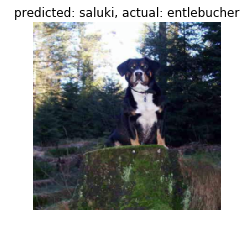

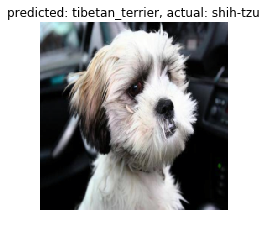

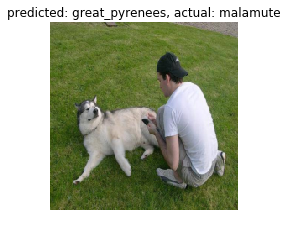

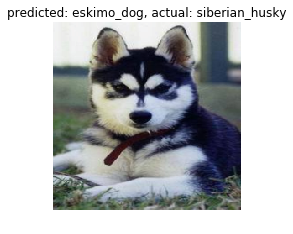

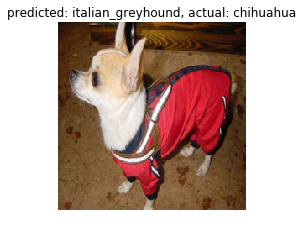

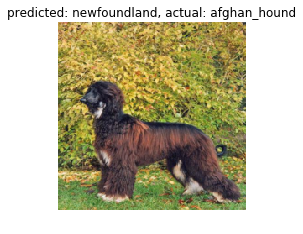

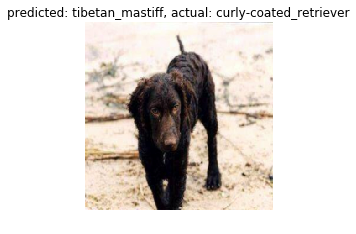

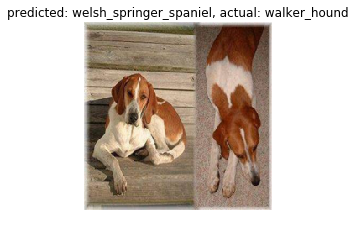

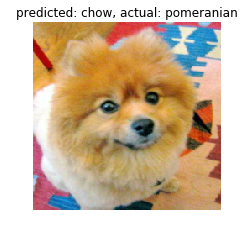

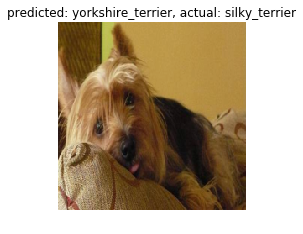

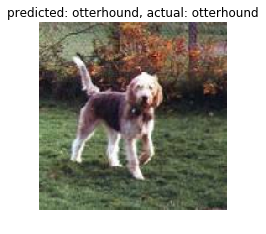

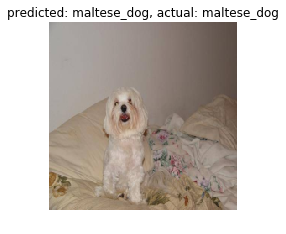

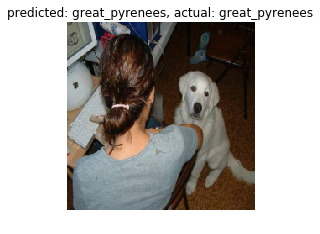

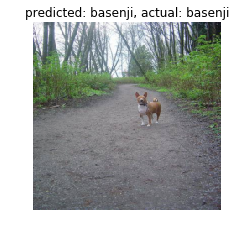

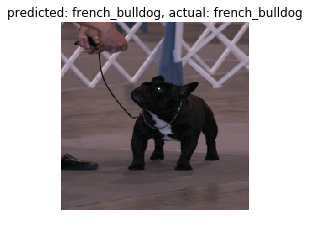

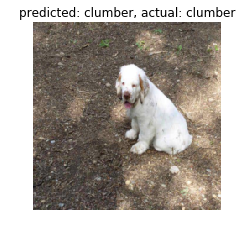

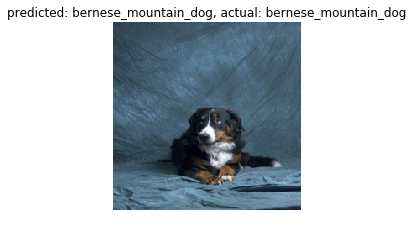

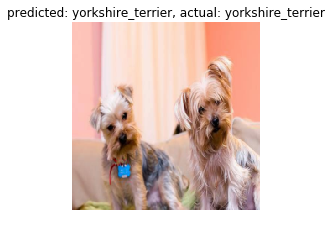

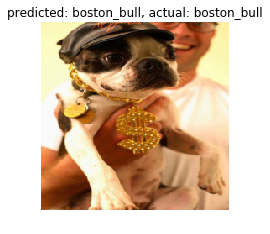

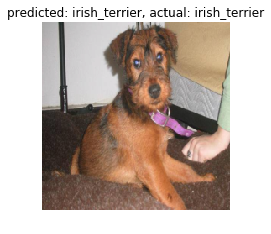

In [62]:
visualize_classifications(alexnet_model, 10, correct=False)
visualize_classifications(alexnet_model, 10, correct=True)